# Evaluation of Deep Learning Architectures for Short-Term Consumption Forecasting in a Resdiential Home

The dataset contains two distinct .csv files which contain information about the consumption patterns of a single family two-story home and weather patterns in Houston for 2016-2020: 

> **`'energy_dataset.csv':`** Contains hourly information about the generation of consumption patterns of a residential home, including when the family left for vactaion 

> **`'weather_features.csv':`** Contains hourly information about the weather conditions (e.g. temperature, wind speed, humidity, rainfall, qualitative desctiption) of Houston Texas

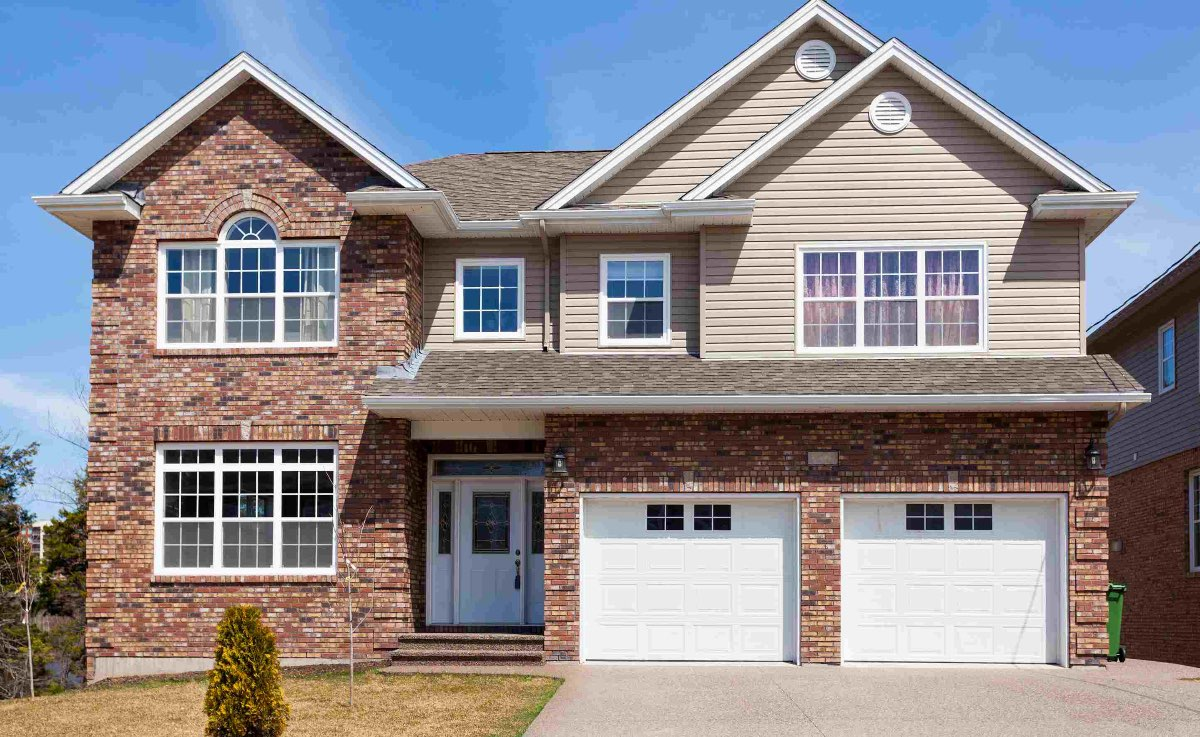

## Import Dependencies

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.constants import convert_temperature
import plotly.express as px

import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout

from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

pd.set_option('display.max_columns', None)

## 1. Preliminary Clean Up & Merging

In [2]:
House = pd.read_csv("/Users/chris/Desktop/Jobs 2.0/Projects/Nueral-Networks-Energy-Forecasting/Notebooks/Data/Residential_Consumption/House.csv")
Weather = pd.read_csv("/Users/chris/Desktop/Jobs 2.0/Projects/Nueral-Networks-Energy-Forecasting/Notebooks/Data/Residential_Consumption/Houston_Weather.csv") 

Lets have a look at both of the datasets that we'll be working with

In [3]:
House.head()

StartDate  Value (kWh)  day_of_week    notes
0  2016-01-06 00:00:00        1.057            2  weekday
1  2016-01-06 01:00:00        1.171            2  weekday
2  2016-01-06 02:00:00        0.560            2  weekday
3  2016-01-06 03:00:00        0.828            2  weekday
4  2016-01-06 04:00:00        0.932            2  weekday

We see that the **House** dataset contains four columns - the date measured by hour, the consumption of the home in Kwh, the day of the week (0 = Monday | 6 = Friday), and notes which includes whether the it is a weekday/weekend, weather it is the Covid-19 Lockdown, and whether or not the family is on vacation.

In [4]:
Weather.head()

# Date UT time  Temperature  Relative Humidity  Pressure  Wind speed  \
0  2016-06-01   01:00       298.78              85.91   1007.74        2.60   
1  2016-06-01   02:00       297.81              88.88   1008.52        2.70   
2  2016-06-01   03:00       297.48              89.31   1008.89        2.94   
3  2016-06-01   04:00       297.16              89.75   1008.53        2.86   
4  2016-06-01   05:00       296.87              89.92   1007.38        2.99   

   Wind direction  Rainfall  Snowfall  Snow depth  Short-wave irradiation  
0          160.93  0.204529       0.0         0.0                 40.4573  
1          178.48  0.700536       0.0         0.0                  0.6854  
2          185.22  0.648280       0.0         0.0                  0.0000  
3          170.63  0.128639       0.0         0.0                  0.0000  
4          150.08  0.009806       0.0         0.0                  0.0000

The **Weather** dataset contains the date, an hour timestamp, as well as various other weather variables. This data was collected form The Modern-Era Retrospective analysis

The **notes** section contains three different varaibles that we would rather have measured independently. The funtions below extact those varaibles and create binary representations for them.

In [5]:
covid = '2020-03-23'

def Covid(data):
    df = House.assign(Covid= 0)
    df.loc[House['StartDate'] > covid, 'Covid'] = 1
    return df

def Vacation(data):
    df = House.assign(Vacation = 0)
    df.loc[House['notes'] == 'vacation', 'Vacation'] = 1
    return df

def Weekend(data):
    df = House.assign(Weekend = 0)
    df.loc[House['notes'] == 'weekend', 'Weekend'] = 1
    return df

House = Covid(House)
House = Vacation(House)
House = Weekend(House)

This fucntion converts the **date** columns to date-time format and deletes columns that we won't be using. It also creates an index column.

In [6]:
def clean_house(data):
    
    data['StartDate'] = data['StartDate'] = pd.to_datetime(data['StartDate']).dt.normalize()
    del data['day_of_week']
    del data['notes']
    data = data.reset_index()  
    
    return data

House = clean_house(House)

This function converts the temperature from Kelvin to Fahrenheit and standardizes the syntax. It also creates an index column. 

In [7]:
def clean_Weather(data):
    
    data['Temperature'] = ((data['Temperature'] - 273.15) * 9/5 + 32).round(2)
    data['UT time'] = data['UT time'].str.replace(r'\:00\b', '')
    data['UT time'] = data['UT time'].astype('float64')
    data = data.reset_index()  
    
    return data

Weather = clean_Weather(Weather)

This function merges the datasets

In [8]:
def merge(data1, data2):

    data = pd.merge(data1, data2, on= "index", how="left")
    del data['StartDate']
    data = data.rename(columns={"# Date": "Date"})
    data = data.rename(columns={"UT time": "Hour"})
    data['Date'] = data['Date'].astype('datetime64[ns]')

    return data

House = merge(House, Weather)

### Merged Dataset

In [9]:
House.head()

index  Value (kWh)  Covid  Vacation  Weekend       Date  Hour  Temperature  \
0      0        1.057      0         0        0 2016-06-01   1.0        78.13   
1      1        1.171      0         0        0 2016-06-01   2.0        76.39   
2      2        0.560      0         0        0 2016-06-01   3.0        75.79   
3      3        0.828      0         0        0 2016-06-01   4.0        75.22   
4      4        0.932      0         0        0 2016-06-01   5.0        74.70   

   Relative Humidity  Pressure  Wind speed  Wind direction  Rainfall  \
0              85.91   1007.74        2.60          160.93  0.204529   
1              88.88   1008.52        2.70          178.48  0.700536   
2              89.31   1008.89        2.94          185.22  0.648280   
3              89.75   1008.53        2.86          170.63  0.128639   
4              89.92   1007.38        2.99          150.08  0.009806   

   Snowfall  Snow depth  Short-wave irradiation  
0       0.0         0.0                 40.4573  
1       0.0         0.0                  0.6854  
2       0.0         0.0                  0.0000  
3       0.0         0.0                  0.0000  
4       0.0         0.0                  0.0000

## 2. Feature Engineering 

In order to map complex consumption patterns of the house, we want to add as many temporal variables as possible. The dict below  will map over the dataset to create a **season** column helping us measure conumption trends. Additoanlly, the function below will add a **Holiday** column, a **Day** column, a **Month** column, and a **Year** column.  

In [10]:
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))

In [11]:
def add_values(data):
    
    Holiday_List = ['25/12/15', '25/12/16', '25/12/17', '25/12/18', '25/12/19', '31/12/15', '31/12/16', '31/12/17', '31/12/18', '31/12/19',
    '04/07/15', '04/07/16', '04/07/17', '04/07/18', '04/07/19', '04/07/20', '26/11/15', '24/11/16', '23/11/17', '22/11/18', '28/11/19', '17/03/15', '17/03/16', 
    '17/03/17', '17/03/18', '17/03/19', ]

    data['Check_Holiday'] = pd.to_datetime(data["Date"]).dt.strftime('%d/%m/%y')
    data['Check_Holiday'] = data['Check_Holiday'].isin(Holiday_List)
    data['Holiday'] = data['Check_Holiday']
    data['Holiday'] = data['Holiday'].astype('float64')
    del data['Check_Holiday']
    
    data['Hour'] = data['Hour'].astype('float64')

    data['Day'] = data['Date'].dt.dayofweek
    data['Day'] = data['Day'].astype('float64')

    data['Month'] = data['Date'].dt.month
    data['Month'] = data['Month'].astype('float64')
    
    data['Year'] = data['Date'].dt.year
    data['Year'] = data['Year'].astype('float64')

    data = data.round(2)
    
    return data

House = add_values(House)

House['Season'] = House.Month.map(month_to_season)

Create a **Working_Hour** column

In [12]:
House['Working_Hour'] = 0

for i in range(len(House)):
    House.loc[(House['Hour'] >= 8.0) & (House['Hour'] <= 17.0),'Working_Hour'] = 1

In [13]:
def Re_order(data):

    Order_list = ['index', 'Date', 'Value (kWh)', 'Hour', 'Working_Hour', 'Day', 'Month', 'Year', 'Season', 'Weekend', 'Holiday', 
                  'Covid', 'Vacation', 'Temperature', 'Relative Humidity', 'Pressure', 'Wind speed',
                  'Wind direction', 'Rainfall', 'Snowfall', 'Snow depth', 'Short-wave irradiation']

    data = data [(Order_list)]
    return data

House = Re_order(House)

This converts the final dataset into a csv file

In [14]:
House.to_csv(r'/Users/chris/Desktop/Jobs 2.0/Projects/Nueral-Networks-Energy-Forecasting/Notebooks/Data/Residential_ConsumptionHouse_Processed.csv', index = False)
House.head()

index       Date  Value (kWh)  Hour  Working_Hour  Day  Month    Year  \
0      0 2016-06-01         1.06   1.0             0  2.0    6.0  2016.0   
1      1 2016-06-01         1.17   2.0             0  2.0    6.0  2016.0   
2      2 2016-06-01         0.56   3.0             0  2.0    6.0  2016.0   
3      3 2016-06-01         0.83   4.0             0  2.0    6.0  2016.0   
4      4 2016-06-01         0.93   5.0             0  2.0    6.0  2016.0   

   Season  Weekend  Holiday  Covid  Vacation  Temperature  Relative Humidity  \
0       3        0      0.0      0         0        78.13              85.91   
1       3        0      0.0      0         0        76.39              88.88   
2       3        0      0.0      0         0        75.79              89.31   
3       3        0      0.0      0         0        75.22              89.75   
4       3        0      0.0      0         0        74.70              89.92   

   Pressure  Wind speed  Wind direction  Rainfall  Snowfall  Snow depth  \
0   1007.74        2.60          160.93      0.20       0.0         0.0   
1   1008.52        2.70          178.48      0.70       0.0         0.0   
2   1008.89        2.94          185.22      0.65       0.0         0.0   
3   1008.53        2.86          170.63      0.13       0.0         0.0   
4   1007.38        2.99          150.08      0.01       0.0         0.0   

   Short-wave irradiation  
0                   40.46  
1                    0.69  
2                    0.00  
3                    0.00  
4                    0.00

In the chart above we see a few notable outliers. In the **value** coulmn we see the max consumption at 6.54 kWh. This is five times the amount of consumption in the 75% percentile. In addittion we see the max **rainfall** is 20000% greater than the 75% percentile and **Short-wave Irridation** is 300% greater than the 75% percentile. Lets plot these values to get a better understanding. 

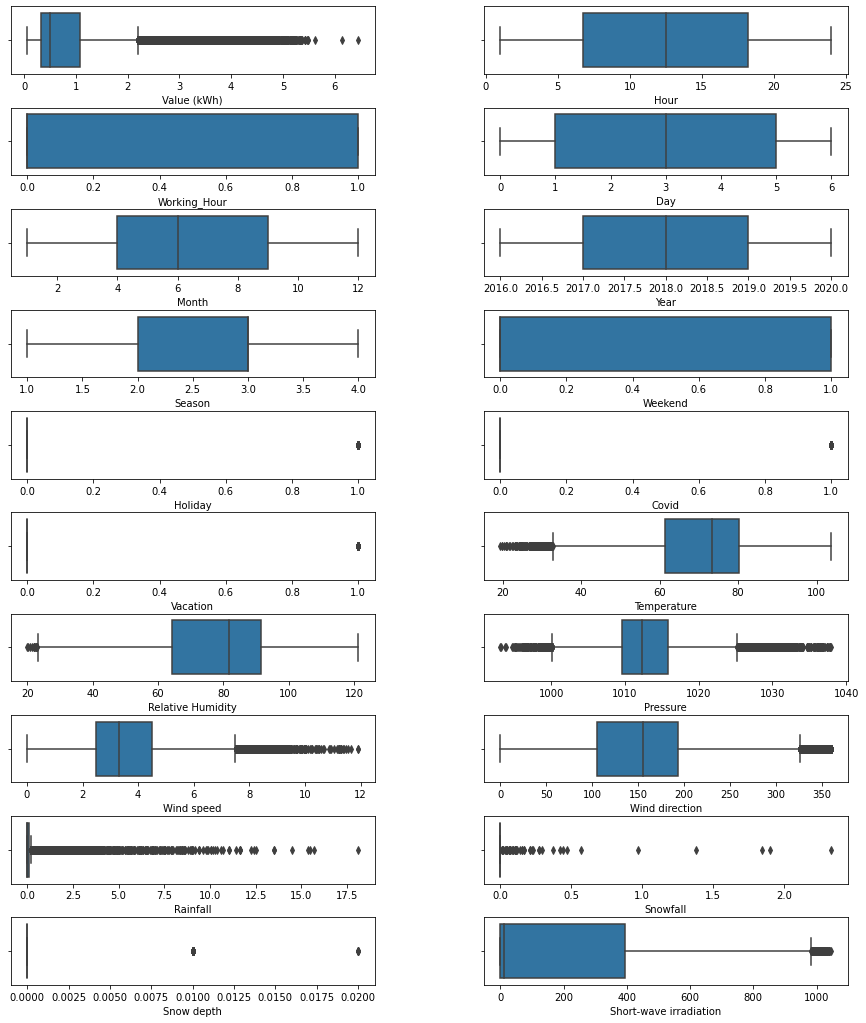

In [15]:
fig, axes = plt.subplots(ncols = 2, nrows = 10, figsize = (15,18))
fig.subplots_adjust(hspace = 0.5, wspace = 0.3)

for ax, col in zip(axes.flatten(), House.columns[2:]):
    sns.boxplot(x = House[col], ax = ax)

Based on the box plots above we can determine that the **Short-wave irradation** value is not anomalous as there is a large cluster of vlaues > 1000. Given that we are in Texas, we can safely assume that the high irradation is from one or more extreme heat events. 

Lets check out the outlier in the rain column

In [16]:
House[House['Rainfall'] > 17].head()

index       Date  Value (kWh)  Hour  Working_Hour  Day  Month    Year  \
25794  25794 2019-05-11          0.6  19.0             0  5.0    5.0  2019.0   

       Season  Weekend  Holiday  Covid  Vacation  Temperature  \
25794       2        0      0.0      0         0        78.33   

       Relative Humidity  Pressure  Wind speed  Wind direction  Rainfall  \
25794              81.66   1004.06        4.46          216.66      18.1   

       Snowfall  Snow depth  Short-wave irradiation  
25794       0.0         0.0                  449.86

We see that the event occured on May 11th 2019, which is the day of a massive flash flood event in Hostoun:

https://www.usatoday.com/story/news/nation/2019/05/11/severe-weather-houston-faces-more-flooding-la-state-emergency/1174543001/

Therefore we can conclude that the value is correctly reported.

Lets have a look at unusually high energy consumption value

In [17]:
pd.set_option('display.max_columns', None)
House[House['Value (kWh)'] > 6]

index       Date  Value (kWh)  Hour  Working_Hour  Day  Month    Year  \
780    780 2016-07-03         6.45  13.0             1  6.0    7.0  2016.0   
781    781 2016-07-03         6.14  14.0             1  6.0    7.0  2016.0   

     Season  Weekend  Holiday  Covid  Vacation  Temperature  \
780       3        0      0.0      0         0        79.70   
781       3        0      0.0      0         0        82.83   

     Relative Humidity  Pressure  Wind speed  Wind direction  Rainfall  \
780              86.95   1011.81        3.85          192.99      0.01   
781              80.73   1012.35        4.38          195.68      0.01   

     Snowfall  Snow depth  Short-wave irradiation  
780       0.0         0.0                  153.69  
781       0.0         0.0                  344.96

We can see that the high level of consumption occured on July 3rd of 2016 between 1 and 2 pm. Lets the plot the homes consumption for the entirety of the month.

In [18]:
start_date = '2016-07-01'
end_date = '2016-07-30'

July = House.loc[House['Date'] >= start_date]
July = July.loc[July['Date'] <= end_date]  

July.tail()

index       Date  Value (kWh)  Hour  Working_Hour  Day  Month    Year  \
1435   1435 2016-07-30         3.59  20.0             0  5.0    7.0  2016.0   
1436   1436 2016-07-30         3.92  21.0             0  5.0    7.0  2016.0   
1437   1437 2016-07-30         5.12  22.0             0  5.0    7.0  2016.0   
1438   1438 2016-07-30         5.08  23.0             0  5.0    7.0  2016.0   
1439   1439 2016-07-30         4.09  24.0             0  5.0    7.0  2016.0   

      Season  Weekend  Holiday  Covid  Vacation  Temperature  \
1435       3        1      0.0      0         0        90.61   
1436       3        1      0.0      0         0        90.46   
1437       3        1      0.0      0         0        89.82   
1438       3        1      0.0      0         0        88.43   
1439       3        1      0.0      0         0        86.63   

      Relative Humidity  Pressure  Wind speed  Wind direction  Rainfall  \
1435              57.10   1011.98        1.79          183.82      0.03   
1436              57.47   1011.62        2.27          176.38      0.03   
1437              59.50   1011.38        2.75          172.25      0.04   
1438              64.69   1011.23        2.92          169.93      0.03   
1439              70.66   1011.29        3.04          169.76      0.05   

      Snowfall  Snow depth  Short-wave irradiation  
1435       0.0         0.0                  583.66  
1436       0.0         0.0                  498.43  
1437       0.0         0.0                  395.36  
1438       0.0         0.0                  265.42  
1439       0.0         0.0                  147.19

In [19]:
import plotly.express as px

df = July
fig = px.line(df, y="Value (kWh)", title='Energy Consumption - July 2016')
fig.show()

We see that the spike is only ~20% higher than the mean peak conusmption in July. Considering that this happened on a weekend and the day before that he 4th of July, it's not unreasonable to assume the family may have had people over and exceeded their typical consumption patterns. 

Curiously, we also see a large dip in the middle of the month where their peak consumption falls by nearly half. Lets explore that dip.

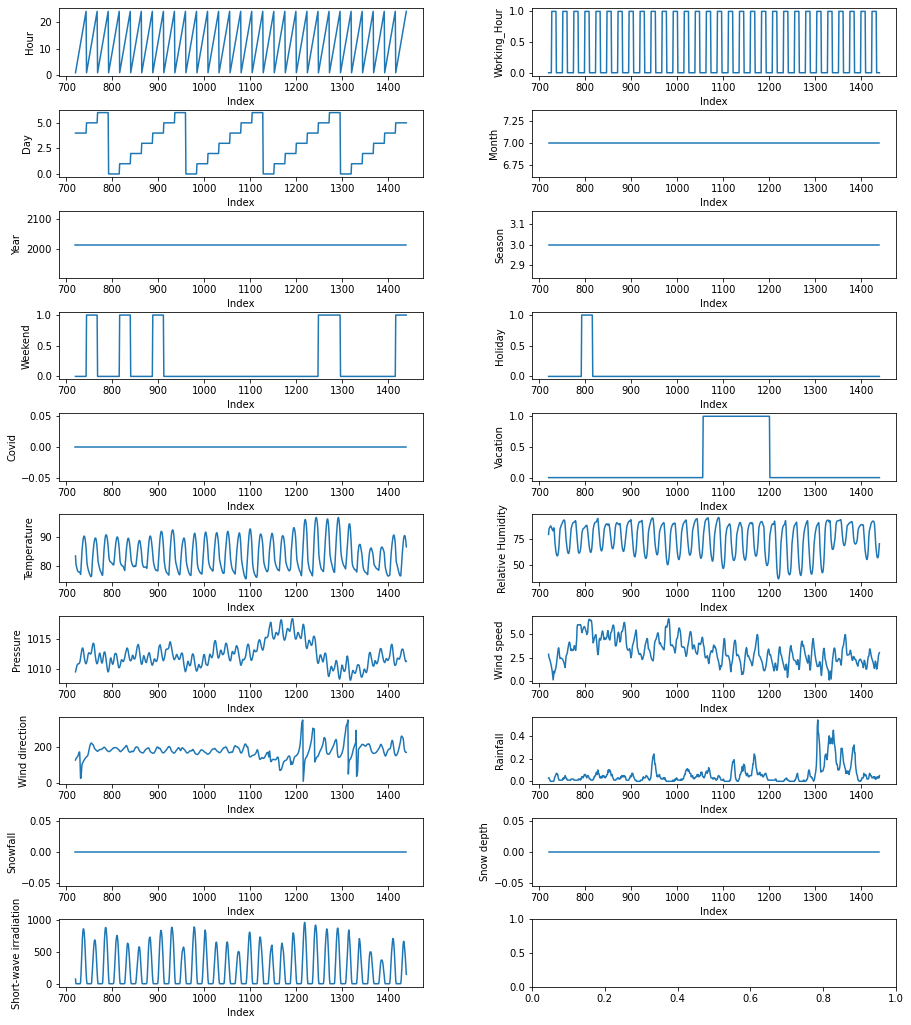

In [20]:
fig, axes = plt.subplots(ncols = 2, nrows = 10, figsize = (15,18))
fig.subplots_adjust(hspace = 0.5, wspace = 0.3)

for ax, col in zip(axes.flatten(), July.columns[3:]):
    sns.lineplot(data = July, x = 'index', y=July[col], ax = ax)
    ax.set(xlabel='Index')

It appears as though the dip is due to the family going on vacation. Lets double check.

In [21]:
July_Dip = July.loc[July['index'] > 1060]
July_Dip = July_Dip.loc[July_Dip['index'] < 1187]

In [22]:
July_Dip.head()

index       Date  Value (kWh)  Hour  Working_Hour  Day  Month    Year  \
1061   1061 2016-07-15         0.19   6.0             0  4.0    7.0  2016.0   
1062   1062 2016-07-15         0.21   7.0             0  4.0    7.0  2016.0   
1063   1063 2016-07-15         0.20   8.0             1  4.0    7.0  2016.0   
1064   1064 2016-07-15         0.18   9.0             1  4.0    7.0  2016.0   
1065   1065 2016-07-15         0.18  10.0             1  4.0    7.0  2016.0   

      Season  Weekend  Holiday  Covid  Vacation  Temperature  \
1061       3        0      0.0      0         1        78.69   
1062       3        0      0.0      0         1        78.35   
1063       3        0      0.0      0         1        78.03   
1064       3        0      0.0      0         1        77.74   
1065       3        0      0.0      0         1        77.63   

      Relative Humidity  Pressure  Wind speed  Wind direction  Rainfall  \
1061              92.95   1012.90        2.50          170.97      0.07   
1062              93.84   1012.85        2.49          175.47      0.08   
1063              94.48   1012.64        2.56          183.78      0.09   
1064              94.94   1012.52        2.63          192.91      0.08   
1065              94.79   1012.51        2.72          199.66      0.07   

      Snowfall  Snow depth  Short-wave irradiation  
1061       0.0         0.0                     0.0  
1062       0.0         0.0                     0.0  
1063       0.0         0.0                     0.0  
1064       0.0         0.0                     0.0  
1065       0.0         0.0                     0.0

We can see that this definitely the case.

Lets check the enterity of the homes conumption to spot any more anomalous trends

In [23]:
df = House
fig = px.line(df, y="Value (kWh)", title='Energy Consumption')
fig.show()

Looking the chart above, we notice another anomaly around index **4900 - 5100, 13,500-14,000** and index **31,000 - 31,400.** Lets check them out

In [24]:
Anomaly_one = House.loc[House['index'] > 4800]
Anomaly_one = Anomaly_one.loc[Anomaly_one['index'] < 5200]

Anomaly_two = House.loc[House['index'] > 13400]
Anomaly_two = Anomaly_two.loc[Anomaly_two['index'] < 13900]

Anomaly_three = House.loc[House['index'] > 31050]
Anomaly_three = Anomaly_three.loc[Anomaly_three['index'] < 31700]

<AxesSubplot:xlabel='index', ylabel='Value (kWh)'>

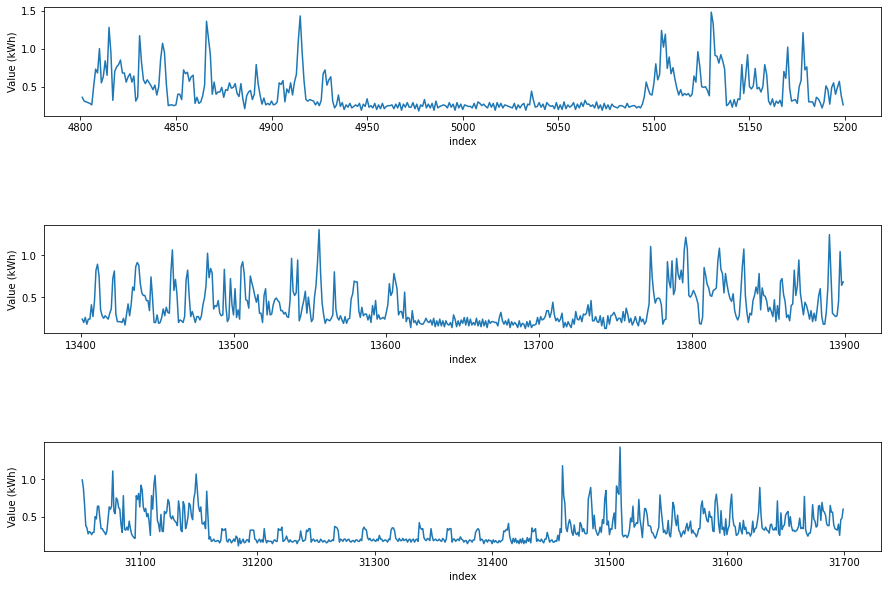

In [25]:
import plotly.express as px

fig, ax = plt.subplots(3)
fig.subplots_adjust(hspace = 1)
fig.set_size_inches(15, 10)

sns.lineplot(data = Anomaly_one, x = 'index', y='Value (kWh)', ax=ax[0])
sns.lineplot(data = Anomaly_two, x = 'index', y='Value (kWh)', ax=ax[1])
sns.lineplot(data = Anomaly_three, x = 'index', y='Value (kWh)', ax=ax[2])

Enegry consumption for all three anamolies drops to near zero. Lets see if we can figure out why. 

In [26]:
Anomaly_one = House.loc[House['index'] > 4933]
Anomaly_one = Anomaly_one.loc[Anomaly_one['index'] < 5093]

Anomaly_two = House.loc[House['index'] > 13650]
Anomaly_two = Anomaly_two.loc[Anomaly_two['index'] < 13780]

Anomaly_three = House.loc[House['index'] > 31168]
Anomaly_three = Anomaly_three.loc[Anomaly_three['index'] < 31457]

In [27]:
print(Anomaly_one['Date'].unique())
print(Anomaly_one['Vacation'].unique())

['2016-12-23T00:00:00.000000000' '2016-12-24T00:00:00.000000000'
 '2016-12-25T00:00:00.000000000' '2016-12-26T00:00:00.000000000'
 '2016-12-27T00:00:00.000000000' '2016-12-28T00:00:00.000000000'
 '2016-12-29T00:00:00.000000000' '2016-12-30T00:00:00.000000000']
[0]


Altough not on vacation, the first time frame runs from December 23rd - December 30th. Since the energy consumption dropped to near zero, it is safe to assume this family went away for the holidays and that this is not misread or anomalous data

In [28]:
print(Anomaly_two['Date'].unique())
print(Anomaly_two['Vacation'].unique())

['2017-12-21T00:00:00.000000000' '2017-12-22T00:00:00.000000000'
 '2017-12-23T00:00:00.000000000' '2017-12-24T00:00:00.000000000'
 '2017-12-25T00:00:00.000000000' '2017-12-26T00:00:00.000000000'
 '2017-12-27T00:00:00.000000000']
[1 0]


In [29]:
print(Anomaly_three['Date'].unique())
print(Anomaly_three['Vacation'].unique())

['2019-12-21T00:00:00.000000000' '2019-12-22T00:00:00.000000000'
 '2019-12-23T00:00:00.000000000' '2019-12-24T00:00:00.000000000'
 '2019-12-25T00:00:00.000000000' '2019-12-26T00:00:00.000000000'
 '2019-12-27T00:00:00.000000000' '2019-12-28T00:00:00.000000000'
 '2019-12-29T00:00:00.000000000' '2019-12-30T00:00:00.000000000'
 '2019-12-31T00:00:00.000000000' '2020-01-01T00:00:00.000000000'
 '2020-01-02T00:00:00.000000000']
[1 0]


The second and thrid time frame runs from December 21st - December 27th/Januray 2nd both mark the family as on vacation - explaining the dip in consumption

## 4. Visualziations

In [30]:
def plot_series(df=None, column=None, series=pd.Series([]), label=None, ylabel=None, title=None, start=0, end=None):
  
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
        
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
        
    if label:
        ax.legend(fontsize=16)
        
    if title:
        ax.set_title(title, fontsize=24)
        
    ax.grid(True)
    return ax

/Users/chris/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Out of curiosity, lets see how the Covid lockdown impacted the homes consumption patterns. Texas issued a lockdown starting on March 24th, so we'll partition the dataset at that point. 

In [31]:
start_date = '2020-03-24'

Covid_19 = House.loc[House['Date'] >= start_date]
print(Covid_19['Date'])

33408   2020-03-24
33409   2020-03-24
33410   2020-03-24
33411   2020-03-24
33412   2020-03-24
           ...    
35947   2020-07-07
35948   2020-07-07
35949   2020-07-07
35950   2020-07-07
35951   2020-07-07
Name: Date, Length: 2544, dtype: datetime64[ns]


Lets grab the data from the same timefram from a year earlier for comparison

In [32]:
start_date = '2019-03-24'
end_date = '2019-07-07'

_2019 = House.loc[House['Date'] >= start_date]
_2019 = _2019.loc[_2019['Date'] <= end_date] 

In [33]:
Covid_19 = Covid_19.reset_index() 
_2019 = _2019.reset_index()

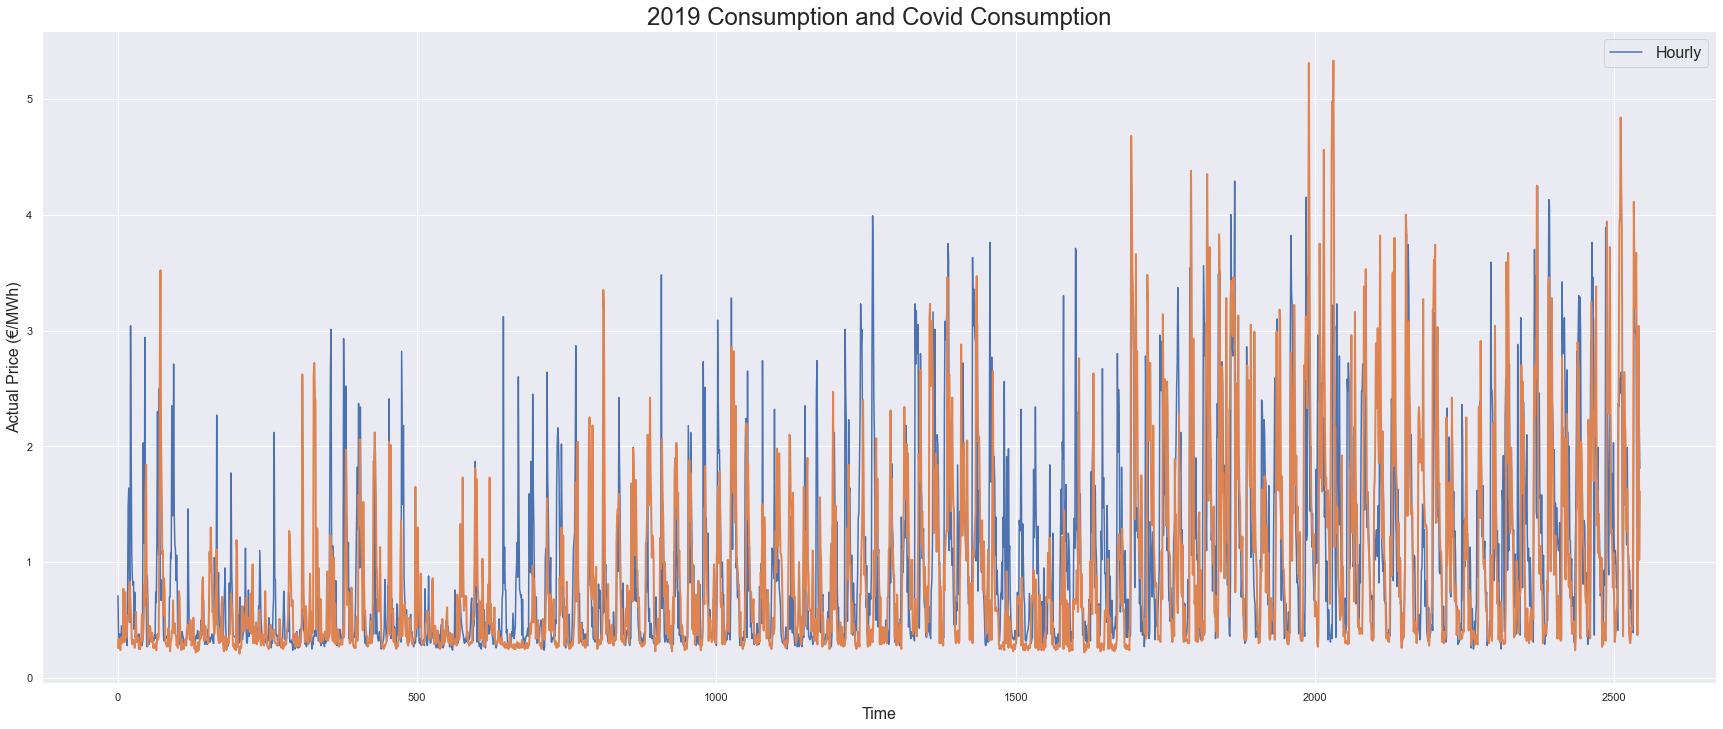

In [34]:
consumption_2019 = _2019['Value (kWh)']
ax = plot_series(Covid_19, 'Value (kWh)', label='Hourly', ylabel= 'Actual Price (€/MWh)',
                 title='2019 Consumption and Covid Consumption')

ax.plot(consumption_2019, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

The **orange** represents **2019 consumption** while the **blue** shows **Covid** consumption. Its a bit diffcilut to 
ascertain how much the pandemic influnced conumption but there seems to be an overall uptick in consumption. Lets look the weekly mean to smooth it out and see if we can get a better understanding. 

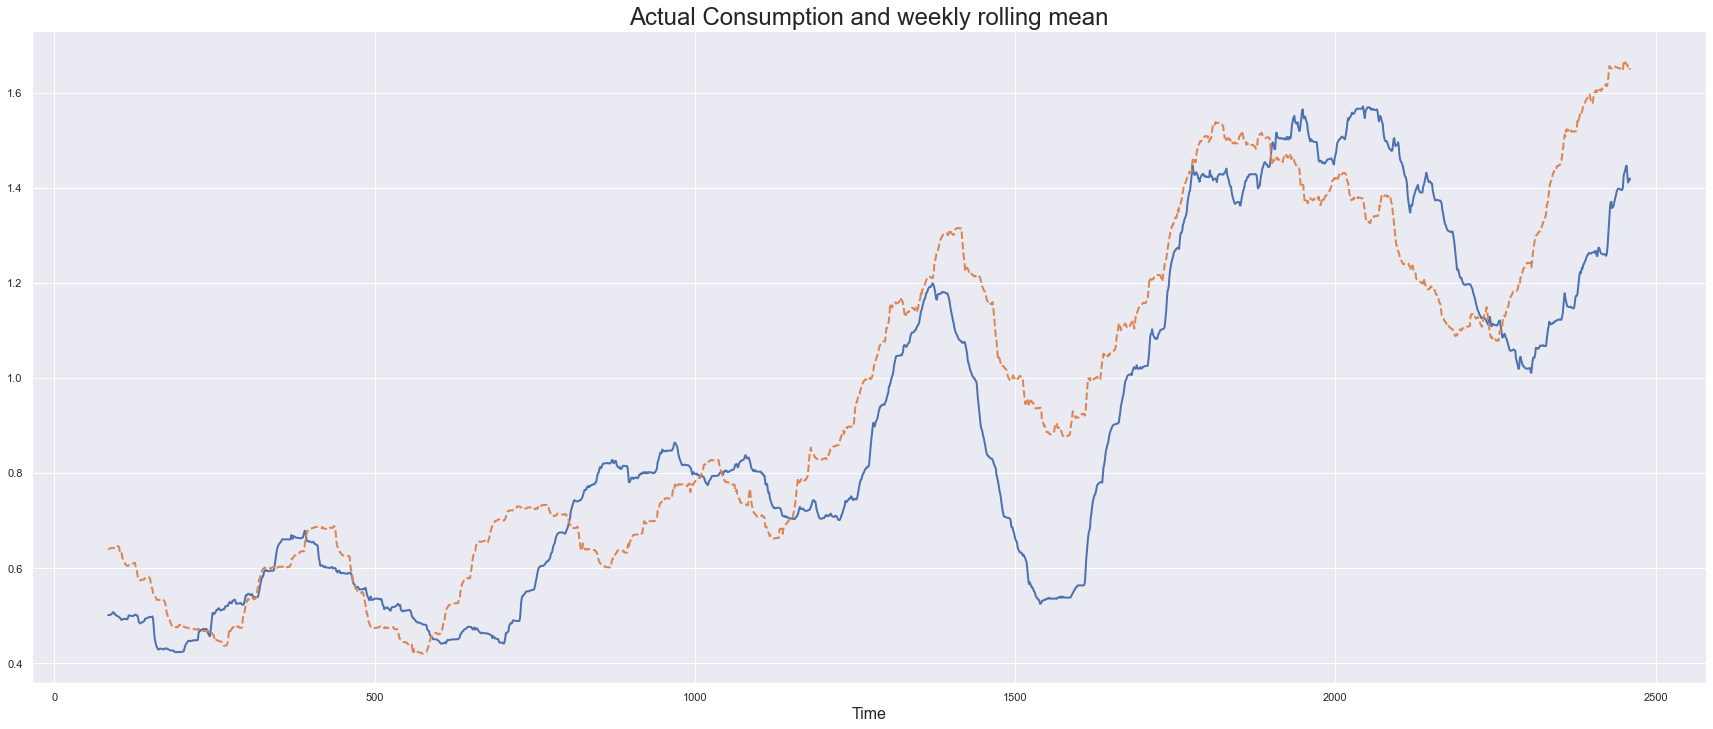

In [35]:
import datetime

consumption_2019_daily = _2019['Value (kWh)'].rolling(24*7, center=True).mean()
Covid_19_daily = Covid_19['Value (kWh)'].rolling(24*7, center=True).mean()

ax = plot_series(title='Actual Consumption and weekly rolling mean')

ax.plot(consumption_2019_daily, linestyle='-', linewidth=2, label='Weekly rolling mean')
ax.plot(Covid_19_daily, linestyle='--', linewidth=2, label='Weekly rolling mean')

plt.show()

Interestingly, consumption patterns aren't all that different. One thing to note is how much smoother the weekly mean is than the daily values. This is common when measuring consumoption data; as you aggreagte, the fucntion becomes much smoother. This is shown below.

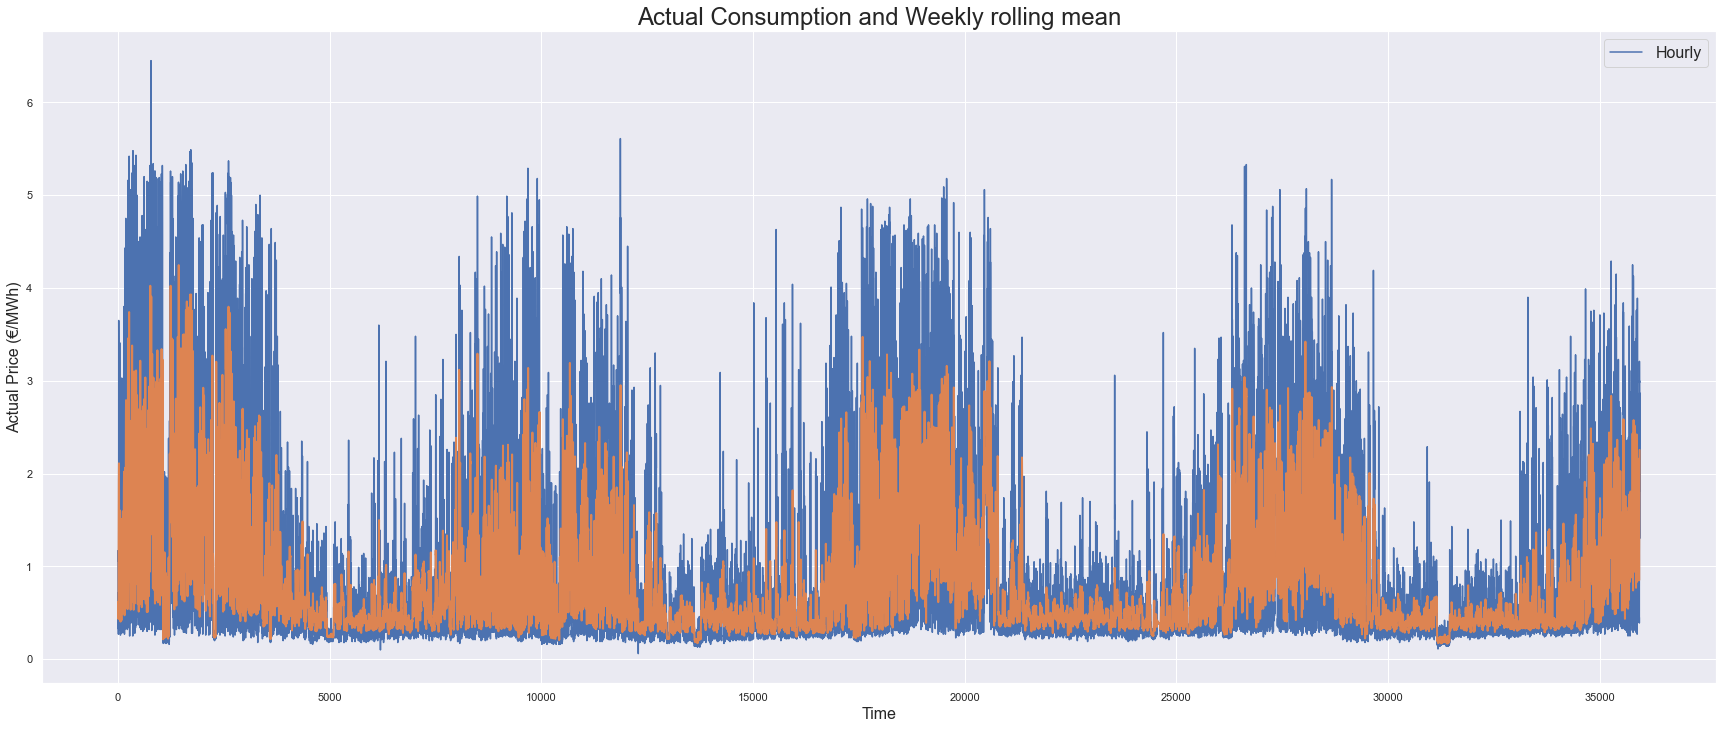

In [36]:
rolling = House['Value (kWh)'].rolling(12, center=True).mean()
ax = plot_series(House, 'Value (kWh)', label='Hourly', ylabel= 'Actual Price (€/MWh)',
                 title='Actual Consumption and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

If you look at the rolling weekly average compared to the hourly values, it's apparent how much smoother aggreate data is. Consequently, it is much harder to predict the variance of hourly consumption trends thna it is weekly or even daily. 

Lets take a closer look at the variance. 

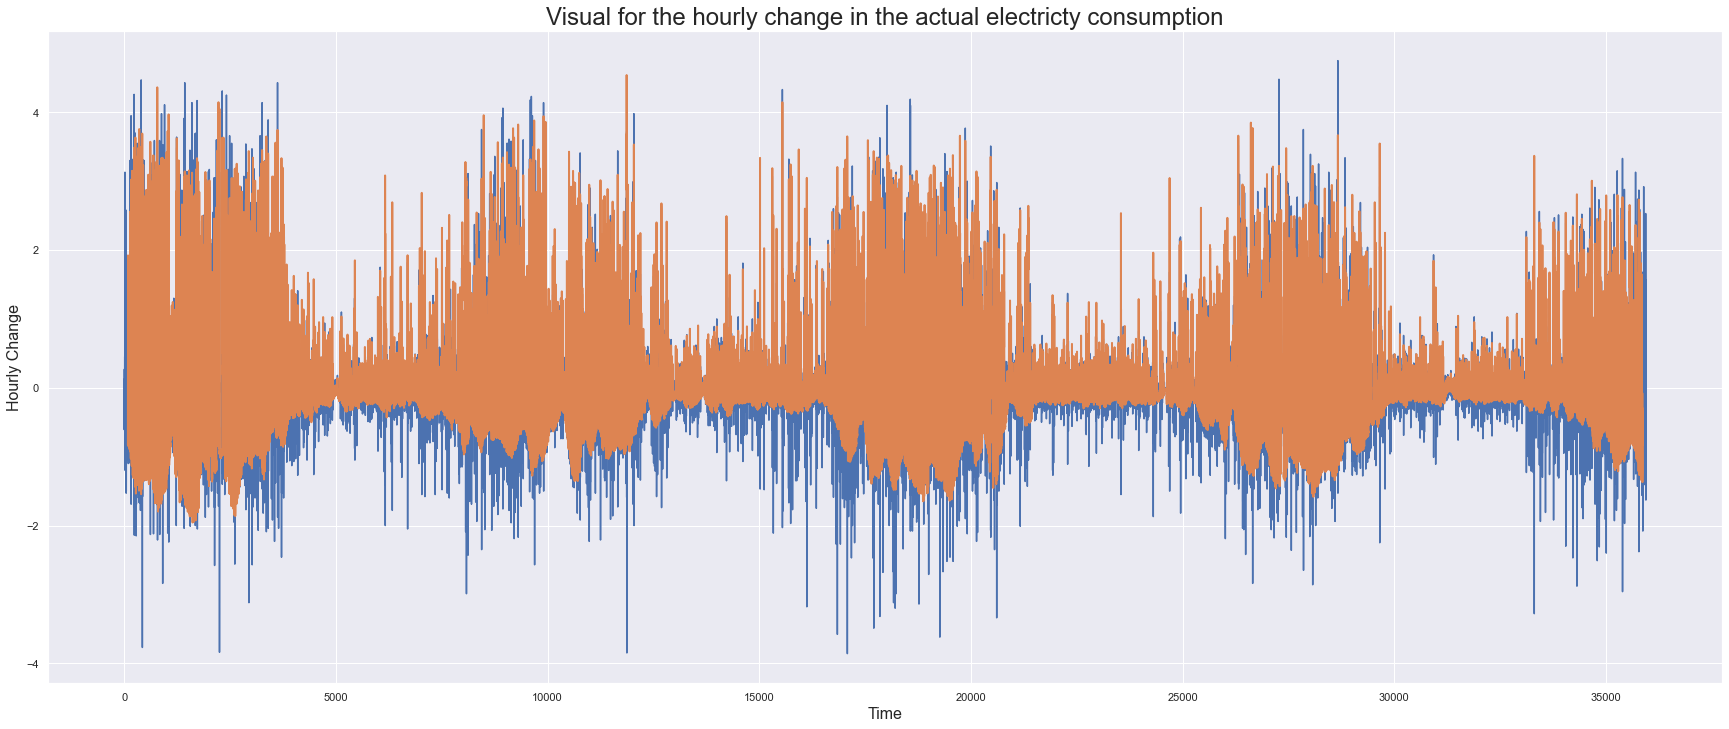

In [37]:
change = House['Value (kWh)'] - House['Value (kWh)'].shift(1)

ax = plot_series(series = change, ylabel='Hourly Change', 
                 title='Visual for the hourly change in the actual electricty consumption')

rolling = House['Value (kWh)'] - House['Value (kWh)'].shift(1).rolling(24*7, center=True).mean()
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

The chart above shows the hour on hour change of consumption plotted against the weekly change. 

Below we measure whether or not the data is stationary 

A stationary time series is one whose properties do not depend on the time at which the series is observed

#### Augmented Dickey-Fuller test

The **Augmented Dickey-Fuller (ADF) test**, a type of unit root test, determines how strongly a time series is defined by a trend. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is not stationary.
- **Alternate Hypothesis** $H_{1}$: The time series has no unit root and is either stationary or can be made stationary using differencing.

In [38]:
from statsmodels.tsa.stattools import adfuller, kpss

y = House['Value (kWh)']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -8.016451
p-value: 0.000000
#Lags used: 50
Critical Value (1%): -3.430532
Critical Value (5%): -2.861621
Critical Value (10%): -2.566813


The ADF statistic (-8.01) is less than the critical value at 1% (-3.431) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is stationary.

#### Kwiatkowski-Phillips-Schmidt-Shin test

The **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**, follows the opposite logic from Augmented Dickey-Fuller test and checks for  stationarity. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: The time series is level, i.e. it is stationary.
- **Alternate Hypothesis** $H_{1}$: There is a unit root in the time series and is not stationary.

In [39]:
kpss_test = kpss(y, regression='c', nlags='legacy')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 2.947503
p-value: 0.010000
#Lags used: 53
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


/Users/chris/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1874: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




The KPSS statistic (2.947) is higher than the critical value at 1% (0.349) and thus, we can say that **we cannot reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that the time series is stationary.

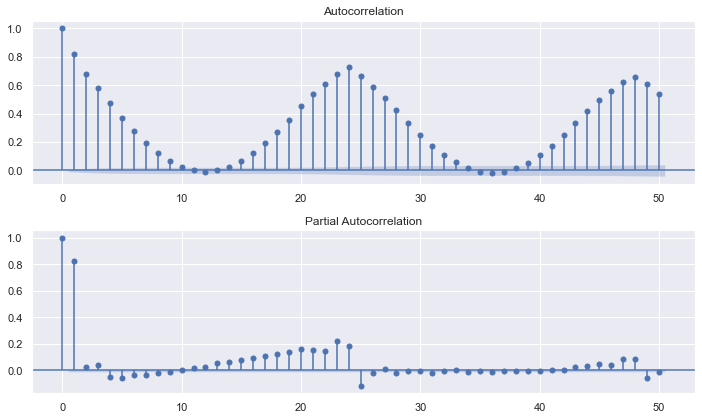

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(House['Value (kWh)'], lags=50, ax=ax1)
plot_pacf(House['Value (kWh)'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

Both the ACF and PACF show seasonality within the dataset. This is unsurprisng given that energy consumption is highly correlated with season.

#### Correlations
Lets take a closer look at the correlations

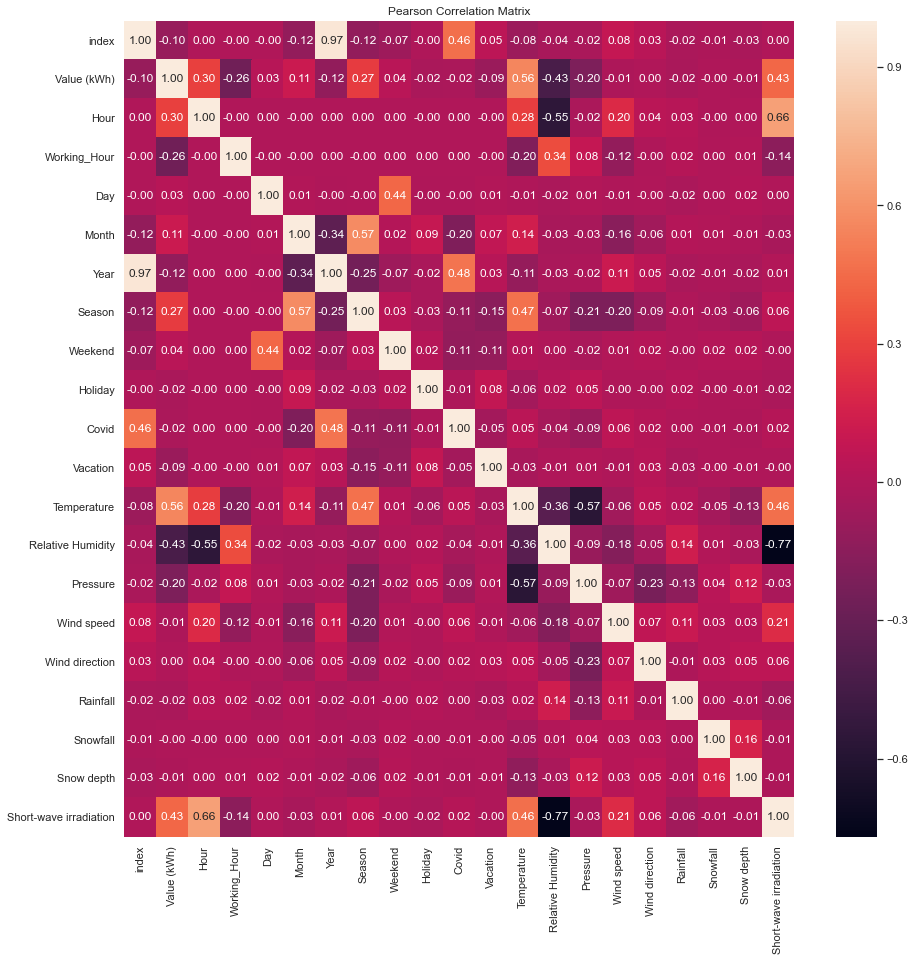

In [41]:
correlations = House.corr(method='pearson')
fig = plt.figure(figsize=(15, 15))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

## 4. Linear Regression

### Daily

In [42]:
Daily = House.groupby(np.arange(len(df))//24).mean()
del Daily['Hour']
Daily.head()

index  Value (kWh)  Working_Hour  Day  Month    Year  Season  Weekend  \
0   11.5     1.236250      0.416667  2.0    6.0  2016.0     3.0      0.0   
1   35.5     1.200000      0.416667  3.0    6.0  2016.0     3.0      1.0   
2   59.5     0.801667      0.416667  4.0    6.0  2016.0     3.0      1.0   
3   83.5     0.952500      0.416667  5.0    6.0  2016.0     3.0      0.0   
4  107.5     1.050417      0.416667  6.0    6.0  2016.0     3.0      0.0   

   Holiday  Covid  Vacation  Temperature  Relative Humidity     Pressure  \
0      0.0    0.0       0.0    77.310833          84.577083  1008.011667   
1      0.0    0.0       0.0    76.743750          91.057917  1008.540833   
2      0.0    0.0       0.0    75.861250          89.055417  1008.082500   
3      0.0    0.0       0.0    73.757500          91.682500  1006.339167   
4      0.0    0.0       0.0    75.100833          85.628333  1005.645833   

   Wind speed  Wind direction  Rainfall  Snowfall  Snow depth  \
0    3.189583      157.746667  0.162917       0.0         0.0   
1    3.869167      165.127917  0.884583       0.0         0.0   
2    2.602500      163.625833  0.559583       0.0         0.0   
3    2.395000      156.532917  4.793750       0.0         0.0   
4    3.515833       34.309167  0.634167       0.0         0.0   

   Short-wave irradiation  
0              170.562917  
1              112.942917  
2              151.554167  
3               82.272500  
4              279.990417

In [43]:
correlations = Daily.corr(method='pearson')
correlations_price = abs(correlations['Value (kWh)'])
print(correlations_price[correlations_price > 0.05]
      .sort_values(ascending=False).to_string())

Value (kWh)               1.000000
Temperature               0.728617
Season                    0.473859
Short-wave irradiation    0.410585
Pressure                  0.319846
Wind speed                0.280933
Relative Humidity         0.214312
Year                      0.211103
Month                     0.195778
index                     0.177437
Vacation                  0.156252
Weekend                   0.067039
Rainfall                  0.055152


In [47]:
df = Daily[['Temperature', 'Season', 'Short-wave irradiation', 'Relative Humidity', 'Year', 'Month', 'Value (kWh)']]

trainSet = df[0:1100]
testSet = df[1100:1498]

XX_elect_train = trainSet.drop('Value (kWh)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Value (kWh)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Value (kWh)']
YY_elect_test = testSet['Value (kWh)']

trainSet.head()

Temperature  Season  Short-wave irradiation  Relative Humidity    Year  \
0    77.310833     3.0              170.562917          84.577083  2016.0   
1    76.743750     3.0              112.942917          91.057917  2016.0   
2    75.861250     3.0              151.554167          89.055417  2016.0   
3    73.757500     3.0               82.272500          91.682500  2016.0   
4    75.100833     3.0              279.990417          85.628333  2016.0   

   Month  Value (kWh)  
0    6.0     1.236250  
1    6.0     1.200000  
2    6.0     0.801667  
3    6.0     0.952500  
4    6.0     1.050417

In [48]:
from sklearn.linear_model import LinearRegression

lr_elect = LinearRegression()
lr_elect.fit(XX_elect_train, YY_elect_train)

y_lr = lr_elect.predict(XX_elect_test)

print ("The test score R2: ", lr_elect.score(XX_elect_test, YY_elect_test))

print ("The Linear Regression coefficients are")
pd.DataFrame(zip(XX_elect_train.columns, lr_elect.coef_), columns = ['elect_features', 'linearRegr_Coefficients'])

The test score R2:  0.705920007690998
The Linear Regression coefficients are


elect_features  linearRegr_Coefficients
0             Temperature                 0.028177
1                  Season                 0.043939
2  Short-wave irradiation                -0.000602
3       Relative Humidity                -0.011207
4                    Year                -0.067812
5                   Month                -0.004179

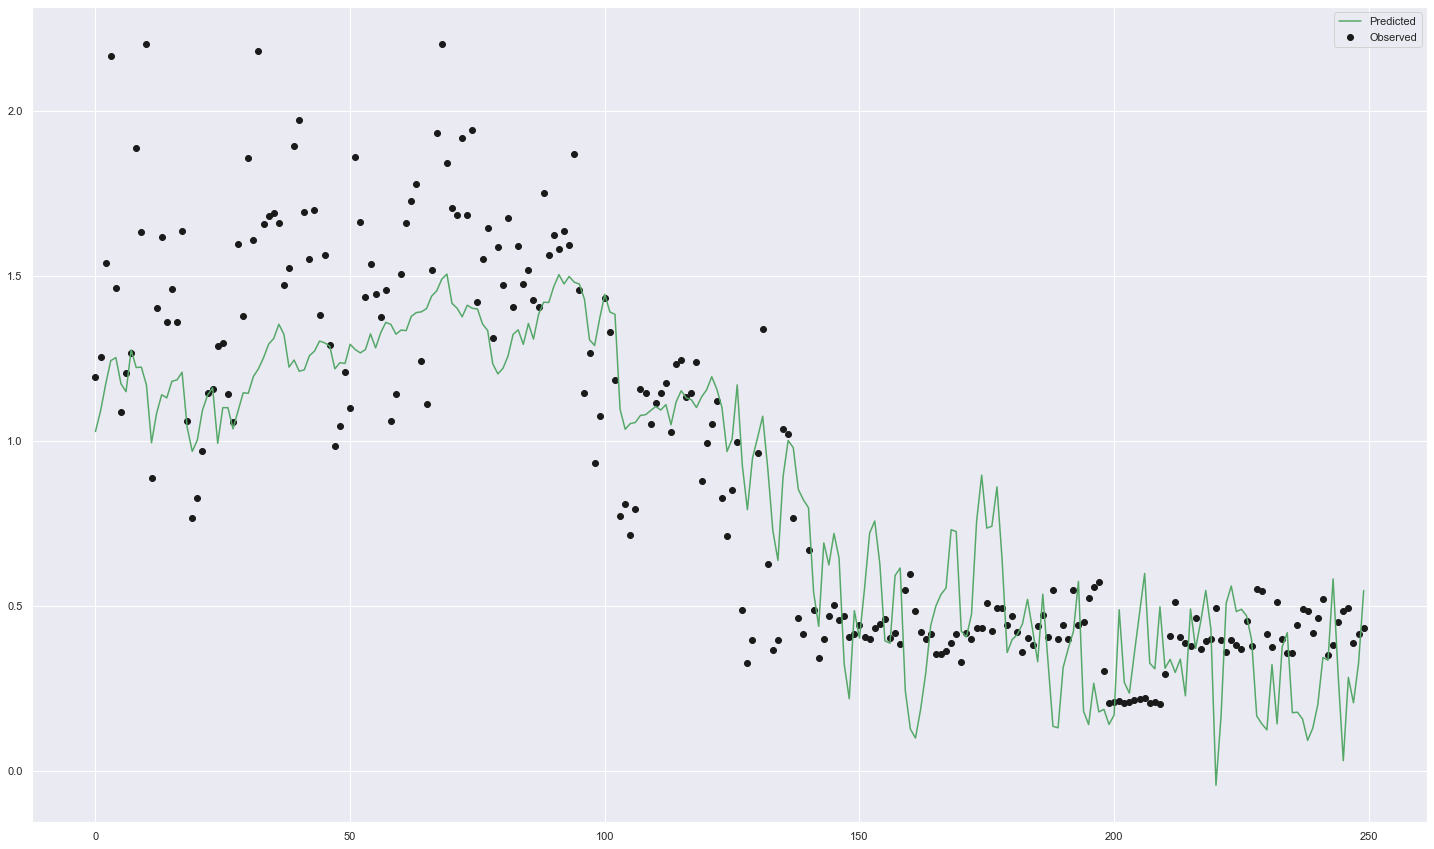

In [49]:
fig = plt.figure(figsize=(25,15))
plt.scatter(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Observed', color='k')
plt.plot(XX_elect_test.index[0:250], y_lr[0:250], label='Predicted', color='g')
plt.legend(loc='upper right')

Text(0.5, 1.0, 'Energy vs Predicted Elec.: $Y_i$ vs $\\hat{Y}_i$')

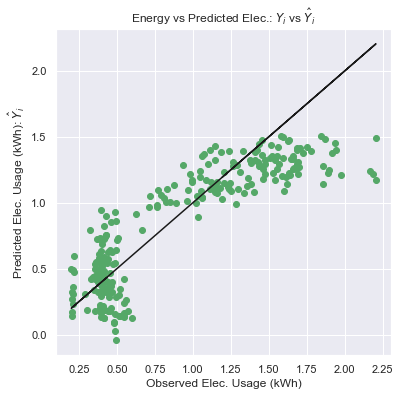

In [50]:
fig = plt.figure(figsize=(6,6))
plt.plot(YY_elect_test[0:250], YY_elect_test[0:250], c='k')
plt.scatter(YY_elect_test[0:250], y_lr[0:250], c='g')
plt.xlabel('Observed Elec. Usage (kWh)')
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$")
plt.title("Energy vs Predicted Elec.: $Y_i$ vs $\hat{Y}_i$")

### Hourly

In [53]:
correlations = House.corr(method='pearson')
correlations_price = abs(correlations['Value (kWh)'])
print(correlations_price[correlations_price > 0.05]
      .sort_values(ascending=False).to_string())

Value (kWh)               1.000000
Temperature               0.556934
Short-wave irradiation    0.433435
Relative Humidity         0.427758
Hour                      0.296628
Season                    0.274625
Working_Hour              0.261367
Pressure                  0.203105
Year                      0.122344
Month                     0.113463
index                     0.102636
Vacation                  0.090453


In [54]:
df = House[['Temperature', 'Short-wave irradiation', 'Relative Humidity', 'Hour', 'Season', 
            'Working_Hour', 'Value (kWh)']]

trainSet = df[0:1100]
testSet = df[1100:1498]

XX_elect_train = trainSet.drop('Value (kWh)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Value (kWh)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Value (kWh)']
YY_elect_test = testSet['Value (kWh)']

trainSet.head()

Temperature  Short-wave irradiation  Relative Humidity  Hour  Season  \
0        78.13                   40.46              85.91   1.0       3   
1        76.39                    0.69              88.88   2.0       3   
2        75.79                    0.00              89.31   3.0       3   
3        75.22                    0.00              89.75   4.0       3   
4        74.70                    0.00              89.92   5.0       3   

   Working_Hour  Value (kWh)  
0             0         1.06  
1             0         1.17  
2             0         0.56  
3             0         0.83  
4             0         0.93

In [55]:
lr_elect = LinearRegression()
lr_elect.fit(XX_elect_train, YY_elect_train)

y_lr = lr_elect.predict(XX_elect_test)

print ("The test score R2: ", lr_elect.score(XX_elect_test, YY_elect_test))

print ("The Linear Regression coefficients are")
pd.DataFrame(zip(XX_elect_train.columns, lr_elect.coef_), columns = ['elect_features', 'linearRegr_Coefficients'])

The test score R2:  0.3429536194324494
The Linear Regression coefficients are


elect_features  linearRegr_Coefficients
0             Temperature                 0.094764
1  Short-wave irradiation                 0.001638
2       Relative Humidity                 0.004087
3                    Hour                 0.011436
4                  Season                 0.000000
5            Working_Hour                -0.591501

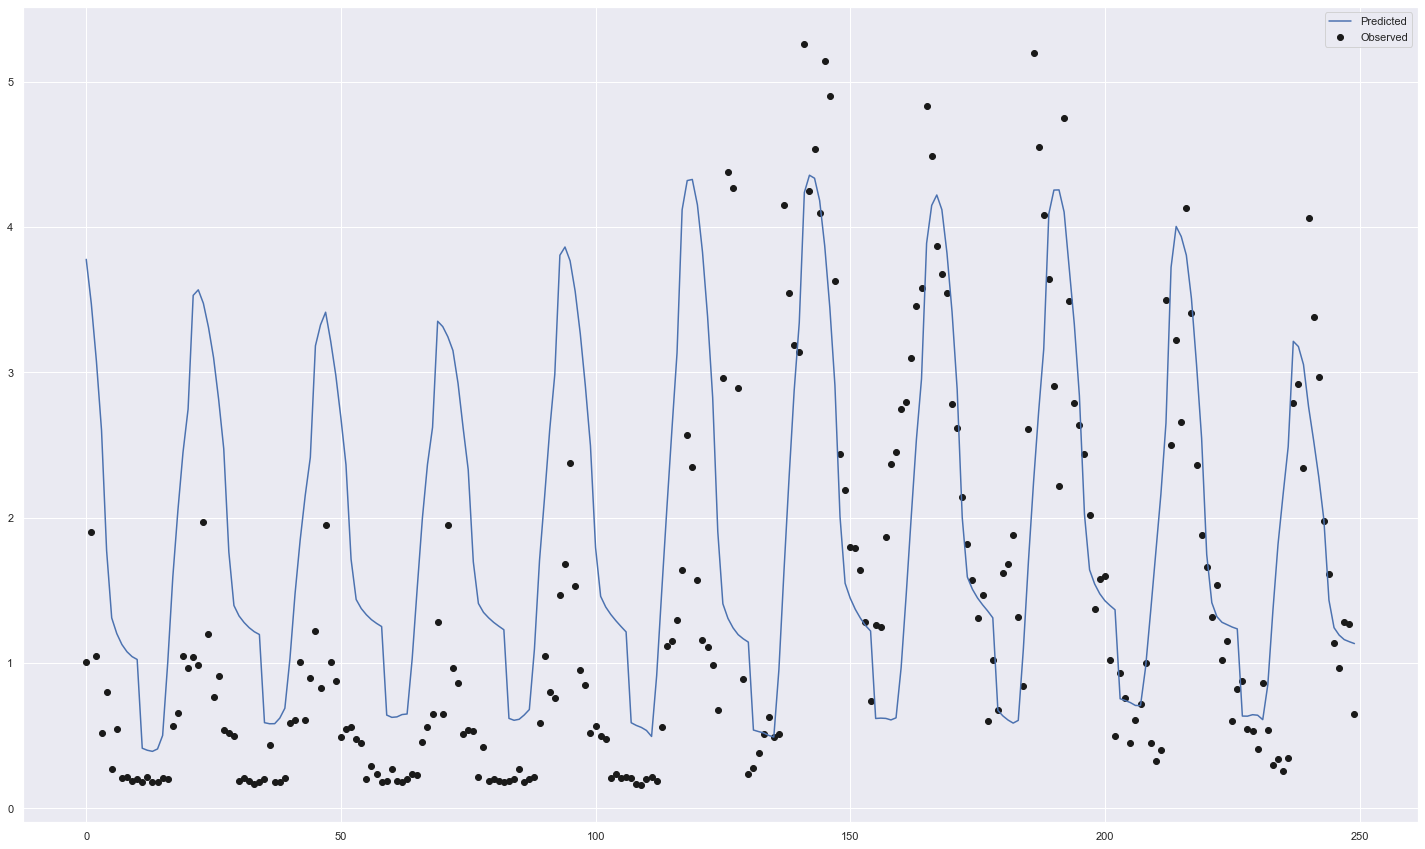

In [56]:
fig = plt.figure(figsize=(25,15))
plt.scatter(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Observed', color='k')
plt.plot(XX_elect_test.index[0:250], y_lr[0:250], label='Predicted', color='b')
plt.legend(loc='upper right')

Text(0.5, 1.0, 'Energy vs Predicted Elec.: $Y_i$ vs $\\hat{Y}_i$')

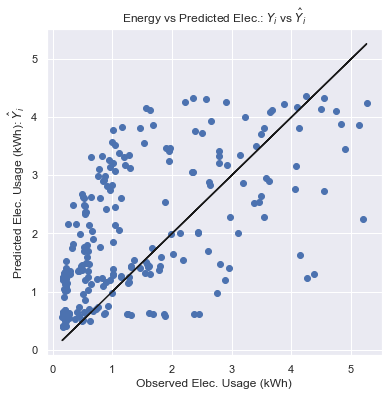

In [57]:
fig = plt.figure(figsize=(6,6))
plt.plot(YY_elect_test[0:250], YY_elect_test[0:250], c='k')
plt.scatter(YY_elect_test[0:250], y_lr[0:250], c='b')
plt.xlabel('Observed Elec. Usage (kWh)')
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$")
plt.title("Energy vs Predicted Elec.: $Y_i$ vs $\hat{Y}_i$")

## KNN

In [58]:
import sklearn
import sklearn.datasets
import sklearn.model_selection
import sklearn.decomposition
import sklearn.neighbors
import sklearn.metrics

In [59]:
normalized_electricity = House['Value (kWh)'] - House['Value (kWh)'].mean()

In [60]:
def accuracy_for_k(k, x, y):
    split_data = sklearn.model_selection.train_test_split(x,y,test_size = 0.33,random_state=99)
    X_train, X_test, Y_train, Y_test = split_data
    knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors = k, weights = 'uniform')
    knn.fit(X_train, Y_train)
    value = knn.score(X_test, Y_test)
    return value

In [61]:
df = House[['Temperature', 'Short-wave irradiation', 'Relative Humidity', 'Hour', 'Season', 
            'Working_Hour', 'Value (kWh)']]

trainSet = df[0:1100]
testSet = df[1100:1498]

XX_elect_train = trainSet.drop('Value (kWh)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Value (kWh)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Value (kWh)']
YY_elect_test = testSet['Value (kWh)']

trainSet.head()

Temperature  Short-wave irradiation  Relative Humidity  Hour  Season  \
0        78.13                   40.46              85.91   1.0       3   
1        76.39                    0.69              88.88   2.0       3   
2        75.79                    0.00              89.31   3.0       3   
3        75.22                    0.00              89.75   4.0       3   
4        74.70                    0.00              89.92   5.0       3   

   Working_Hour  Value (kWh)  
0             0         1.06  
1             0         1.17  
2             0         0.56  
3             0         0.83  
4             0         0.93

0.5203608612687566
The optimal value of k is: 9


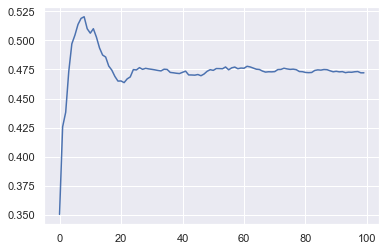

In [62]:
k_values=range(1,101)
scores=np.zeros(len(k_values))
for k, c_k in zip(k_values,range(len(k_values))):
    value=accuracy_for_k(k=k,x= XX_elect_train,y = YY_elect_train)
    scores[c_k]=value
    
k_opt=np.argmax(scores)+1
print (scores.max())
print ('The optimal value of k is:',k_opt)

line1, = plt.plot(scores.T)

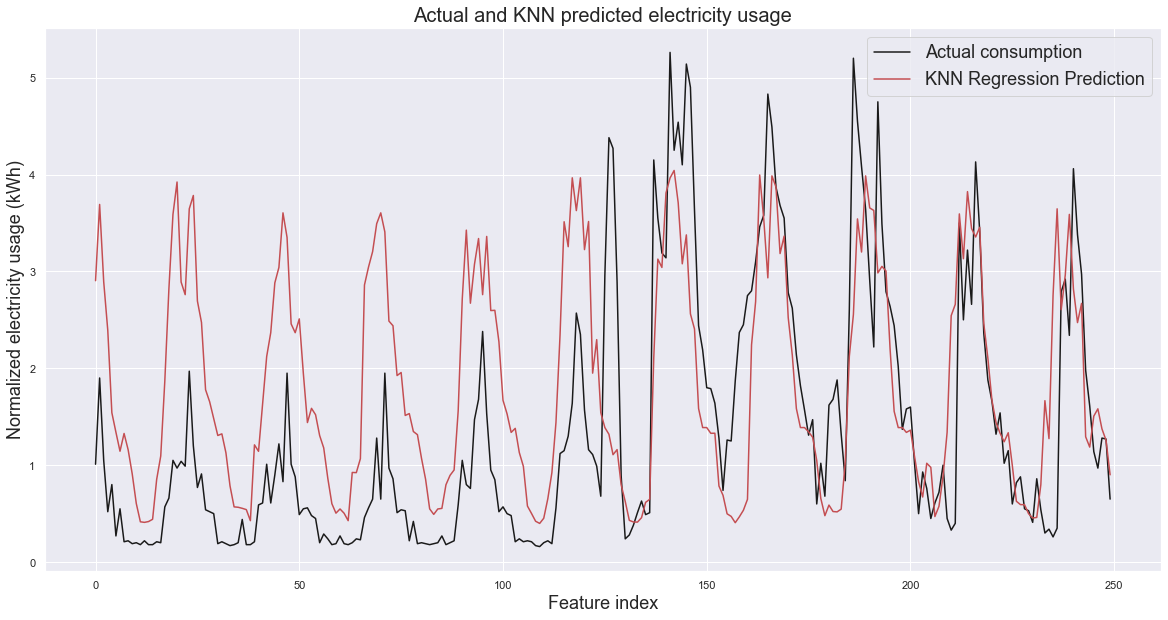

In [63]:
knn_reg=sklearn.neighbors.KNeighborsRegressor(n_neighbors=12,weights='uniform')
knn_reg.fit(XX_elect_train,YY_elect_train)
YY_elect_pred=knn_reg.predict(XX_elect_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, = plt.plot(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Actual consumption', color='k')
line2, = plt.plot(XX_elect_test.index[0:250], YY_elect_pred[0:250], label='KNN Regression Prediction', color='r')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized electricity usage (kWh)',fontsize=18)
plt.title('Actual and KNN predicted electricity usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'KNN Regression Prediction'],fontsize=18)
plt.show()

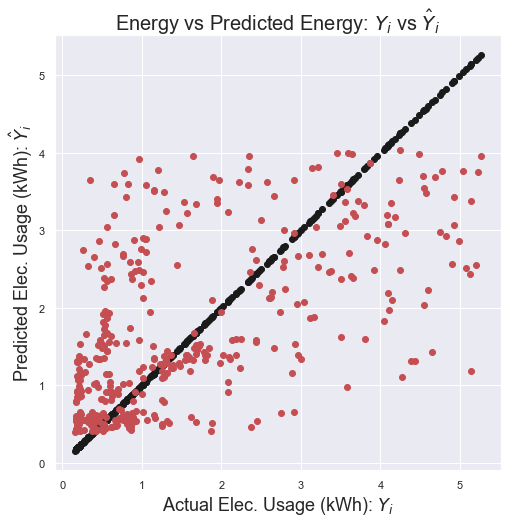

In [64]:
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_elect_test, YY_elect_test, c='k')
plt.scatter(YY_elect_test, YY_elect_pred, c='r')
plt.xlabel('Actual Elec. Usage (kWh): $Y_i$',fontsize=18)
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$",fontsize=18)

plt.title("Energy vs Predicted Energy: $Y_i$ vs $\hat{Y}_i$",fontsize=20)
plt.show()

## Random Forest

In [65]:
df = House[['Temperature', 'Short-wave irradiation', 'Relative Humidity', 'Hour', 'Season', 
            'Working_Hour', 'Value (kWh)']]

trainSet = df[0:1100]
testSet = df[1100:1498]

XX_elect_train = trainSet.drop('Value (kWh)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Value (kWh)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Value (kWh)']
YY_elect_test = testSet['Value (kWh)']

trainSet.head()

Temperature  Short-wave irradiation  Relative Humidity  Hour  Season  \
0        78.13                   40.46              85.91   1.0       3   
1        76.39                    0.69              88.88   2.0       3   
2        75.79                    0.00              89.31   3.0       3   
3        75.22                    0.00              89.75   4.0       3   
4        74.70                    0.00              89.92   5.0       3   

   Working_Hour  Value (kWh)  
0             0         1.06  
1             0         1.17  
2             0         0.56  
3             0         0.83  
4             0         0.93

In [66]:
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.model_selection import cross_val_score

estimators = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
mean_rfrs = []
std_rfrs_upper = []
std_rfrs_lower = []
yt = [i for i in YY_elect_train]
np.random.seed(11111)

for i in estimators:
    
    model = rfr(n_estimators = i, max_depth = None)
    scores_rfr = cross_val_score(model, XX_elect_train, yt, cv = 10, scoring = 'explained_variance')
    
    print('estimators:', i)
    print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_rfr.mean(), scores_rfr.std() * 2))
    print('')
    
    mean_rfrs.append(scores_rfr.mean())
    std_rfrs_upper.append(scores_rfr.mean() + scores_rfr.std()*2) 
    std_rfrs_lower.append(scores_rfr.mean() - scores_rfr.std()*2)

estimators: 2
Est. explained variance: 0.38 (+/- 0.31)

estimators: 5
Est. explained variance: 0.51 (+/- 0.24)

estimators: 10
Est. explained variance: 0.56 (+/- 0.23)

estimators: 15
Est. explained variance: 0.58 (+/- 0.24)

estimators: 20
Est. explained variance: 0.59 (+/- 0.22)

estimators: 25
Est. explained variance: 0.59 (+/- 0.21)

estimators: 30
Est. explained variance: 0.60 (+/- 0.22)

estimators: 35
Est. explained variance: 0.61 (+/- 0.24)

estimators: 40
Est. explained variance: 0.60 (+/- 0.24)

estimators: 45
Est. explained variance: 0.59 (+/- 0.22)

estimators: 50
Est. explained variance: 0.60 (+/- 0.22)

estimators: 55
Est. explained variance: 0.60 (+/- 0.23)

estimators: 60
Est. explained variance: 0.60 (+/- 0.22)

estimators: 65
Est. explained variance: 0.60 (+/- 0.23)

estimators: 70
Est. explained variance: 0.60 (+/- 0.22)

estimators: 75
Est. explained variance: 0.60 (+/- 0.22)

estimators: 80
Est. explained variance: 0.60 (+/- 0.23)



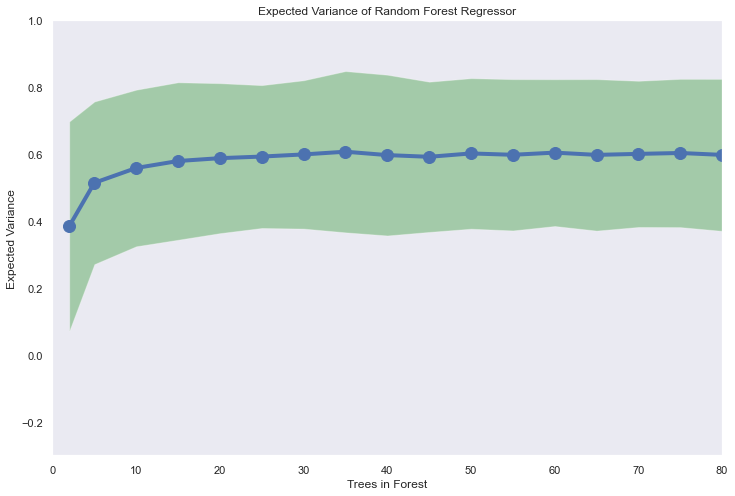

In [67]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111)
ax.plot(estimators,mean_rfrs,marker='o',
       linewidth=4,markersize=12)

ax.fill_between(estimators,std_rfrs_lower,std_rfrs_upper,
                facecolor='green',alpha=0.3,interpolate=True)

ax.set_ylim([-.3,1])
ax.set_xlim([0,80])
plt.title('Expected Variance of Random Forest Regressor')
plt.ylabel('Expected Variance')
plt.xlabel('Trees in Forest')
plt.grid()
plt.show()

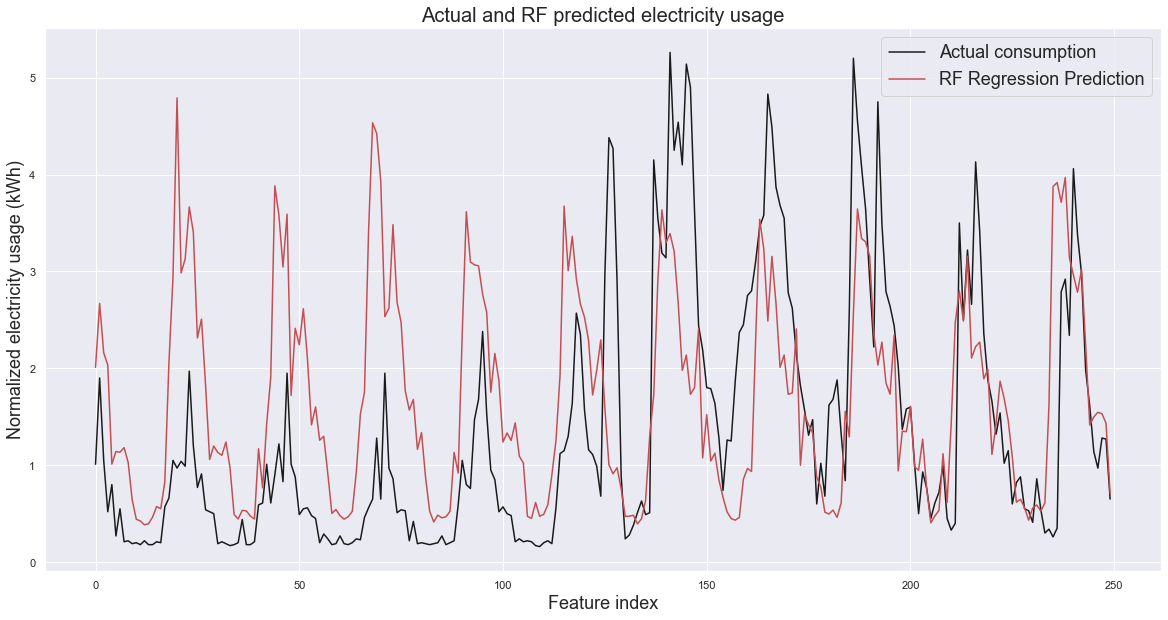

In [68]:
from sklearn.ensemble import RandomForestRegressor

RF_e = RandomForestRegressor(n_estimators = 20, max_depth=None, min_samples_split = 4, random_state=0)
RF_e.fit(XX_elect_train, YY_elect_train)
YY_elect_pred=RF_e.predict(XX_elect_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, =plt.plot(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Actual consumption', color='k')
line2, =plt.plot(XX_elect_test.index[0:250], YY_elect_pred[0:250], label='RF Regression Prediction', color='r')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized electricity usage (kWh)',fontsize=18)
plt.title('Actual and RF predicted electricity usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'RF Regression Prediction'],fontsize=18)
plt.show()

In [69]:
print (RF_e.score(XX_elect_test,YY_elect_test))

0.3051774436606002


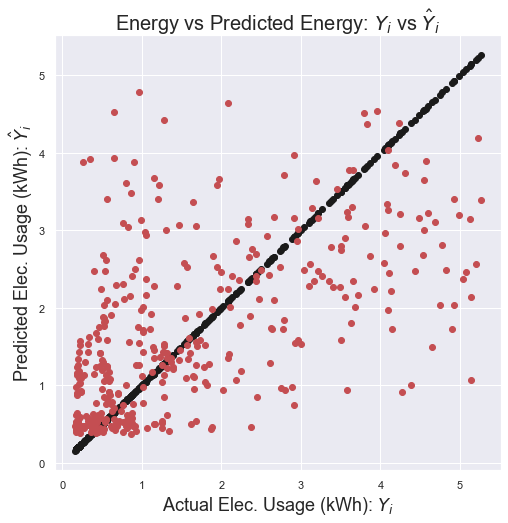

In [70]:
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_elect_test, YY_elect_test, c='k')
plt.scatter(YY_elect_test, YY_elect_pred, c='r')
plt.xlabel('Actual Elec. Usage (kWh): $Y_i$',fontsize=18)
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$",fontsize=18)
plt.title("Energy vs Predicted Energy: $Y_i$ vs $\hat{Y}_i$",fontsize=20)
plt.show()

## 5. Feature Selection

Before we can process the data through any models, we need to format it (scale, get rid of nulls, split into sets, etc)

First, lets find the values that correlate the most with the homes consumption pattern. These will be the features we use to train our models on. We'll choose all features that have an absolute coorelative value greater than 20%

In [71]:
correlations = House.corr(method='pearson')
correlations_price = abs(correlations['Value (kWh)'])
print(correlations_price[correlations_price > 0.20]
      .sort_values(ascending=False).to_string())

Value (kWh)               1.000000
Temperature               0.556934
Short-wave irradiation    0.433435
Relative Humidity         0.427758
Hour                      0.296628
Season                    0.274625
Working_Hour              0.261367
Pressure                  0.203105


In [72]:
features = ['Temperature', 'Relative Humidity', 'Short-wave irradiation', 'Hour', 'Working_Hour', 'Pressure',
           'Season', 'Month']

Next we need to chek for null values as the model will not work if the dataset contains any missing values

In [73]:
House.isnull().any()

index                     False
Date                      False
Value (kWh)               False
Hour                      False
Working_Hour              False
Day                       False
Month                     False
Year                      False
Season                    False
Weekend                   False
Holiday                   False
Covid                     False
Vacation                  False
Temperature               False
Relative Humidity         False
Pressure                  False
Wind speed                False
Wind direction            False
Rainfall                  False
Snowfall                  False
Snow depth                False
Short-wave irradiation    False
dtype: bool

We see that there are null values in the consumption difference columns. This is due to the values being determined by previous values. Which means the first few rows in each column will be blank as they won't have enough predecessor rows to make the caluculation. 

A solution to this, altough maybe not the best, is to fill the valeus with the mean value for each column. This would not be a great solution if there were many null vlaues, but since the maximum amount nulls is 12, it likely not effect the model given the dataset consist of ~36,000 rows.

The function below is to plot the loss and rmse values for each model. It will be called on after training. 

In [74]:
def plot_model_rmse_and_loss(history):
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

This function is to plot the learning rate for each model. It will be called on after training. 

In [75]:
def plot_learning_rate_schedule(history_lr, max_loss):
    plt.semilogx(history_lr.history['lr'], history_lr.history['loss'])
    plt.axis([1e-4, 1, 0, max_loss])
    plt.xlabel('Learning Rate')
    plt.ylabel('Training Loss')
    plt.show()

### Naive Hour Ahead Model

Before we make any predictions we need to have a baseline value for comparison. The naive model below takes the Root Mean Square Error of hour on hour intervals. 

In [76]:
def naive(Data):
    
    y = House['Value (kWh)'].values

    y_train = y[:25166]
    y_cv = y[25166 : 30559]
    y_test = y[30559:]
    
    naive_hour_ahead = y[30559 - 1 : 35952 - 1]
    rmse_naive = sqrt(mean_squared_error(y_test, naive_hour_ahead))

    print('RMSE of hour-ahead electricity price naive forecast: {}'.format(round(rmse_naive, 3)))

naive(House)

RMSE of hour-ahead electricity price naive forecast: 0.432


This is the **baseline** value we want our model to exceed

### Model Pre-Processing

The function below helps create the target, validation, and test set

In [77]:
def Nueral_Network (dataset, target, start, end, timesteps):
    
    data = []
    labels = []

    if end is None:
        end = len(dataset)
        
    for i in range(start, end):
        
        indices = range(i - timesteps, i)
        data.append(dataset[indices])
        labels.append(target[i])

    return np.array(data), np.array(labels)

Defines where in the dataset to split that various datasets. This is using a 70/15/15 split on training, testing, and validation respectively.

In [78]:
train_set = 25166
validation_set = 30559
test_set = 35952

Selects the relevent features

In [79]:
dataset = House[features]

These next few bits define all the parameters necessary to train, test, and analyze the network. 

- **Scales**: 
- **Creates the datasets**: 
- **Defines the loss value**: 
- **Defines the metric value**: 
- **Defines the learning schedule**: 
- **Defines the batch and shuffle size**: 
- **Shuffles the training and validation sets**: 

In [80]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

timesteps = 3
scaler_all = MinMaxScaler(feature_range=(0, 1))
scaler_all.fit(dataset[:train_set])
scaled_dataset = scaler_all.transform(dataset)

House = House['Value (kWh)'].values
scaler = MinMaxScaler(feature_range=(0, 1))

House_reshaped = House.reshape(-1, 1)
scaler.fit(House_reshaped[:train_set])

scaled_variable = scaler.transform(House_reshaped)
scaled_dataset = np.concatenate((scaled_dataset, scaled_variable), axis=1)

X_test, y_test = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], validation_set, test_set, timesteps)

In [81]:
X_train, y_train = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], 0, train_set, timesteps)
X_val, y_val = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], train_set, validation_set, timesteps)
X_test, y_test = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], validation_set, test_set, timesteps)

In [82]:
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 10))

y_test_reshaped = y_test.reshape(-1, 1)
y_test_inv = scaler.inverse_transform(y_test_reshaped)

batch_size = 128
shuffle_size = 128

val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val = val.cache().shuffle(shuffle_size).batch(shuffle_size).prefetch(1)

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(shuffle_size).batch(shuffle_size).prefetch(1)

## Multilayer Perceptron

The first step is to define the leraning rate. The learning rate helps define how the size of the **step** each iteration takes along the gradient. We will figure out the ideal learning rate by running a few iterations of a simple model and then plotting the self-adjusting learning to measure where the loss is the lowest

In [83]:
tf.keras.backend.clear_session()
from keras import regularizers

mlp_lr = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, kernel_regularizer=regularizers.l2(0.0009), activation='relu'), input_shape = input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr = 1e-4, amsgrad=True)
mlp_lr.compile(loss=loss, optimizer=optimizer, metrics=metric)

Using TensorFlow backend.


In [84]:
Learning_Rate = mlp_lr.fit(train, epochs = 50, validation_data = val, callbacks=[lr_schedule])

Epoch 1/50
197/197 [==============================] - 1s 5ms/step - loss: 0.0337 - root_mean_squared_error: 0.1383 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1243
Epoch 2/50
197/197 [==============================] - 1s 4ms/step - loss: 0.0225 - root_mean_squared_error: 0.0982 - val_loss: 0.0206 - val_root_mean_squared_error: 0.0927
Epoch 3/50
197/197 [==============================] - 1s 4ms/step - loss: 0.0186 - root_mean_squared_error: 0.0858 - val_loss: 0.0180 - val_root_mean_squared_error: 0.0871
Epoch 4/50
197/197 [==============================] - 1s 4ms/step - loss: 0.0160 - root_mean_squared_error: 0.0796 - val_loss: 0.0155 - val_root_mean_squared_error: 0.0814
Epoch 5/50
197/197 [==============================] - 1s 4ms/step - loss: 0.0142 - root_mean_squared_error: 0.0776 - val_loss: 0.0145 - val_root_mean_squared_error: 0.0832
Epoch 6/50
197/197 [==============================] - 1s 4ms/step - loss: 0.0129 - root_mean_squared_error: 0.0775 - val_loss: 0.0136 - val_

197/197 [==============================] - 1s 3ms/step - loss: 0.0754 - root_mean_squared_error: 0.2527 - val_loss: 0.0267 - val_root_mean_squared_error: 0.1621
Epoch 49/50
197/197 [==============================] - 1s 3ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 50/50
197/197 [==============================] - 1s 4ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan


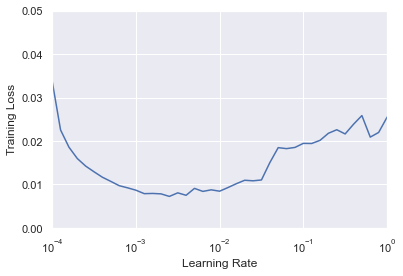

In [85]:
plot_learning_rate_schedule(Learning_Rate, 0.05)

We see by the chart above that the ideal learning rate is 0.001.

In [86]:
tf.keras.backend.clear_session()

MLP =  tf.keras.models.Sequential([
    TimeDistributed(Dense(150, kernel_regularizer=regularizers.l2(0.001), activation='relu'), input_shape = input_shape),
    TimeDistributed(Dense(100, kernel_regularizer=regularizers.l2(0.001), activation='relu')),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)  
])

optimizer = tf.keras.optimizers.Adam(lr = 0.001, amsgrad= True)
MLP.compile(loss = loss, optimizer = optimizer, metrics = metric)
MLP_Model = MLP.fit(train, epochs = 100, validation_data = val)

Epoch 1/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0722 - root_mean_squared_error: nan - val_loss: 0.0476 - val_root_mean_squared_error: 0.1459
Epoch 2/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0271 - root_mean_squared_error: 0.0939 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1300
Epoch 3/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0169 - root_mean_squared_error: 0.0871 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1232
Epoch 4/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0132 - root_mean_squared_error: 0.0868 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1306
Epoch 5/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0113 - root_mean_squared_error: 0.0860 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1254
Epoch 6/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0103 - root_mean_squared_error: 0.0861 - val_loss: 0.0175 - v

197/197 [==============================] - 1s 3ms/step - loss: 0.0070 - root_mean_squared_error: 0.0794 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0904
Epoch 49/100
197/197 [==============================] - 0s 2ms/step - loss: 0.0070 - root_mean_squared_error: 0.0798 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0906
Epoch 50/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0070 - root_mean_squared_error: 0.0799 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0914
Epoch 51/100
197/197 [==============================] - 0s 2ms/step - loss: 0.0070 - root_mean_squared_error: 0.0796 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0924
Epoch 52/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0070 - root_mean_squared_error: 0.0799 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0922
Epoch 53/100
197/197 [==============================] - 0s 2ms/step - loss: 0.0070 - root_mean_squared_error: 0.0797 - val_loss: 0.0088 - val_r

197/197 [==============================] - 1s 3ms/step - loss: 0.0067 - root_mean_squared_error: 0.0785 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0862
Epoch 96/100
197/197 [==============================] - 0s 2ms/step - loss: 0.0067 - root_mean_squared_error: 0.0789 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0872
Epoch 97/100
197/197 [==============================] - 0s 2ms/step - loss: 0.0067 - root_mean_squared_error: 0.0789 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0871
Epoch 98/100
197/197 [==============================] - 0s 2ms/step - loss: 0.0067 - root_mean_squared_error: 0.0789 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0873
Epoch 99/100
197/197 [==============================] - 0s 2ms/step - loss: 0.0067 - root_mean_squared_error: 0.0789 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0869
Epoch 100/100
197/197 [==============================] - 1s 4ms/step - loss: 0.0067 - root_mean_squared_error: 0.0790 - val_loss: 0.0078 - val_

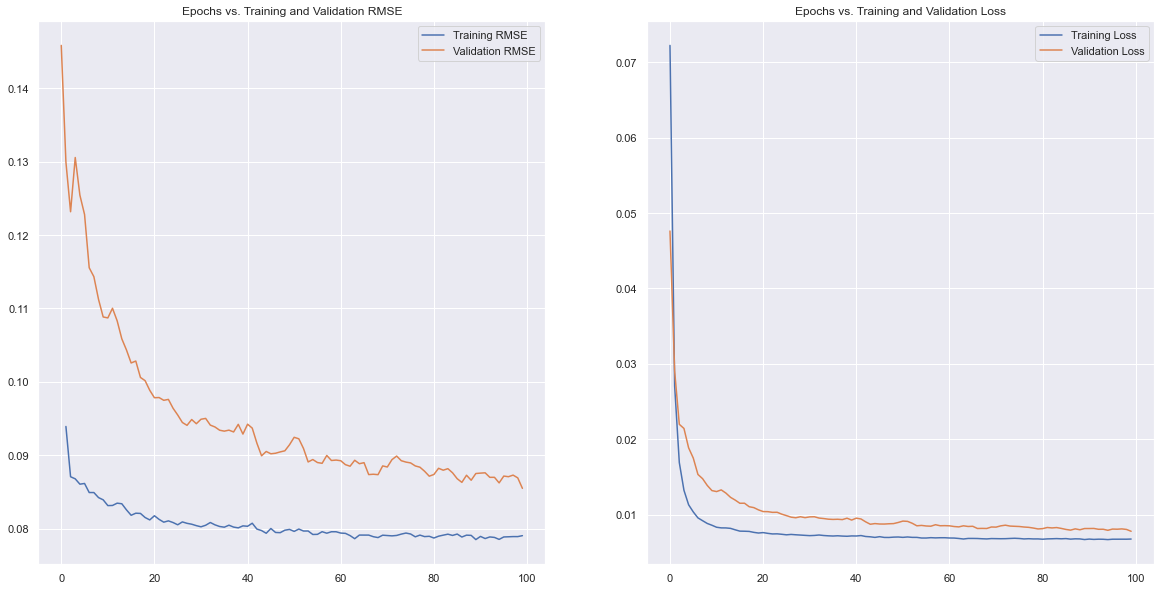

In [87]:
plot_model_rmse_and_loss(MLP_Model)

In [88]:
forecast = MLP.predict(X_test)
MLP_forecast = scaler.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test, MLP_forecast))
print('RMSE of hour-ahead electricity price multivariate MLP forecast: {}' .format(round(rmse_lstm, 3)))

RMSE of hour-ahead electricity price multivariate MLP forecast: 0.691


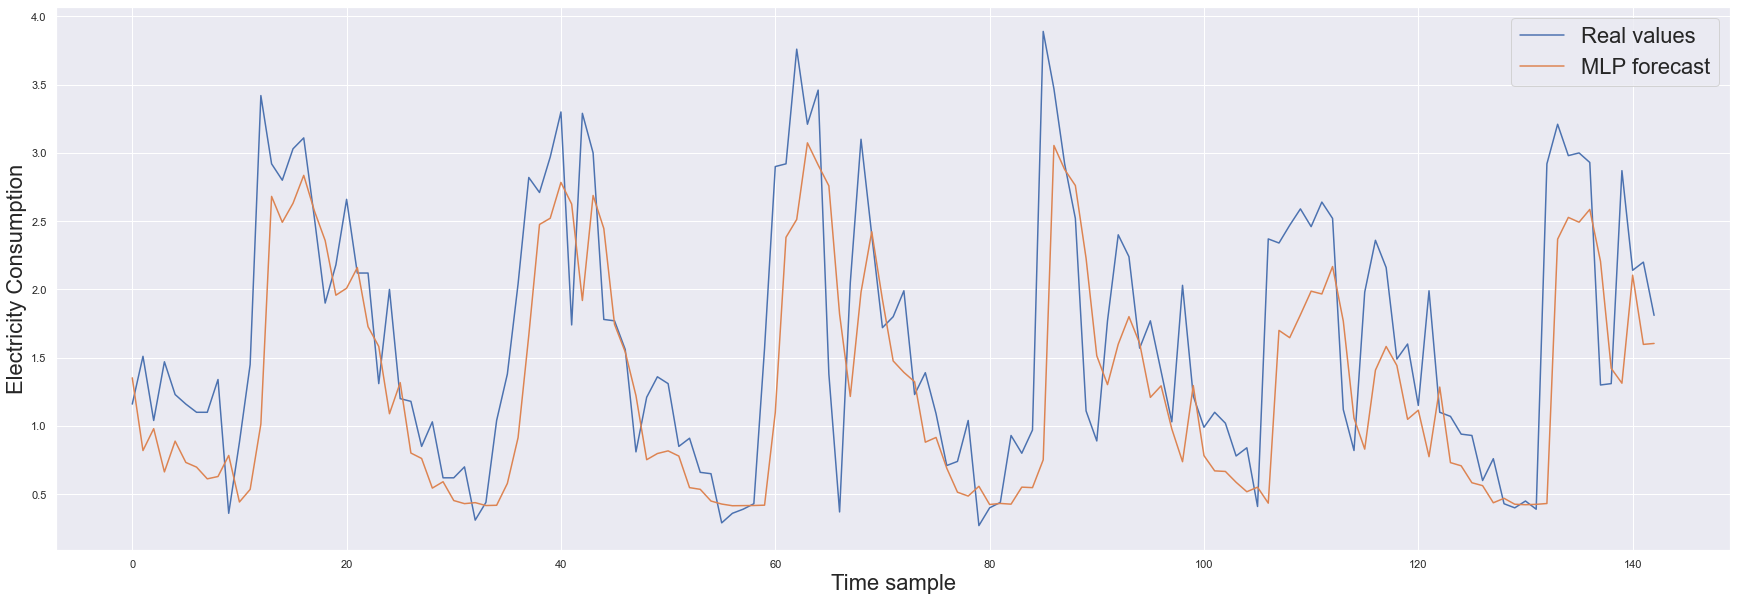

In [89]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[5250:], label='Real values')
ax.plot(MLP_forecast[5250:], label='MLP forecast')
ax.legend(prop={'size':22})
plt.show()

We only ran 50 epochs beacuse the model was over-fitting expotentially as the epochs increase. As you can see the modle has diffculty predicting the peaks and valleys of the homes consumption. This is very notable around the ~115th time sample where consumption takes a big dip and the model can't map it. Overall, the model performed worse than the naive estimate making it inefficnet for proper testing.

## LSTM

The first step is to again run a simple model and discover and ideal leraning rate.

In [90]:
tf.keras.backend.clear_session()

lstm_learning = tf.keras.models.Sequential([
    LSTM(50, input_shape = input_shape, return_sequences=True),
    Flatten(),
    Dense(100, kernel_regularizer=regularizers.l2(0.0009), activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
lstm_learning.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [91]:
Learning_Rate = lstm_learning.fit(train, epochs = 50, validation_data = val, callbacks = [lr_schedule])

Epoch 1/50
197/197 [==============================] - 1s 6ms/step - loss: 0.1179 - root_mean_squared_error: 0.1311 - val_loss: 0.1060 - val_root_mean_squared_error: 0.1291
Epoch 2/50
197/197 [==============================] - 1s 4ms/step - loss: 0.0938 - root_mean_squared_error: 0.1192 - val_loss: 0.0834 - val_root_mean_squared_error: 0.1136
Epoch 3/50
197/197 [==============================] - 1s 4ms/step - loss: 0.0726 - root_mean_squared_error: 0.1063 - val_loss: 0.0630 - val_root_mean_squared_error: 0.1003
Epoch 4/50
197/197 [==============================] - 1s 4ms/step - loss: 0.0546 - root_mean_squared_error: 0.0980 - val_loss: 0.0470 - val_root_mean_squared_error: 0.0947
Epoch 5/50
197/197 [==============================] - 1s 4ms/step - loss: 0.0407 - root_mean_squared_error: 0.0939 - val_loss: 0.0354 - val_root_mean_squared_error: 0.0941
Epoch 6/50
197/197 [==============================] - 1s 4ms/step - loss: 0.0304 - root_mean_squared_error: 0.0911 - val_loss: 0.0288 - val_

197/197 [==============================] - 1s 4ms/step - loss: 0.5033 - root_mean_squared_error: 0.1574 - val_loss: 0.0655 - val_root_mean_squared_error: 0.1962
Epoch 49/50
197/197 [==============================] - 1s 4ms/step - loss: 1.2386 - root_mean_squared_error: 0.1664 - val_loss: 0.0696 - val_root_mean_squared_error: 0.2286
Epoch 50/50
197/197 [==============================] - 1s 4ms/step - loss: 0.6728 - root_mean_squared_error: 0.2921 - val_loss: 0.0501 - val_root_mean_squared_error: 0.1682


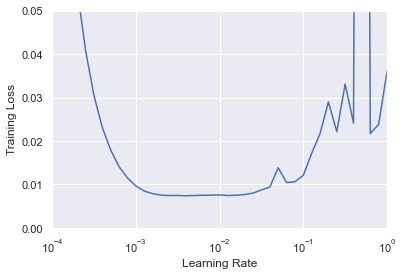

In [92]:
plot_learning_rate_schedule(Learning_Rate, 0.05)

We see by the chart above that the ideal learning rate is 0.001.

In [93]:
tf.keras.backend.clear_session()

LSTM = tf.keras.models.Sequential([
    LSTM(100, input_shape = input_shape, return_sequences = True),
    Flatten(),
    Dense(150, kernel_regularizer=regularizers.l2(0.0009), activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr = .001, amsgrad=True)
LSTM.compile(loss = loss, optimizer = optimizer, metrics = metric)
LSTM_Model = LSTM.fit(train, epochs = 75, validation_data = val)  

Epoch 1/75
197/197 [==============================] - 2s 8ms/step - loss: 0.0766 - root_mean_squared_error: 0.1209 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1418
Epoch 2/75
197/197 [==============================] - 1s 6ms/step - loss: 0.0187 - root_mean_squared_error: 0.0979 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1436
Epoch 3/75
197/197 [==============================] - 1s 6ms/step - loss: 0.0115 - root_mean_squared_error: 0.0939 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1228
Epoch 4/75
197/197 [==============================] - 1s 7ms/step - loss: 0.0092 - root_mean_squared_error: 0.0890 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1119
Epoch 5/75
197/197 [==============================] - 1s 6ms/step - loss: 0.0082 - root_mean_squared_error: 0.0856 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1064
Epoch 6/75
197/197 [==============================] - 1s 7ms/step - loss: 0.0077 - root_mean_squared_error: 0.0833 - val_loss: 0.0107 - val_

197/197 [==============================] - 1s 6ms/step - loss: 0.0059 - root_mean_squared_error: 0.0755 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0823
Epoch 49/75
197/197 [==============================] - 1s 6ms/step - loss: 0.0060 - root_mean_squared_error: 0.0761 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0806
Epoch 50/75
197/197 [==============================] - 1s 6ms/step - loss: 0.0059 - root_mean_squared_error: 0.0756 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0811
Epoch 51/75
197/197 [==============================] - 1s 7ms/step - loss: 0.0059 - root_mean_squared_error: 0.0756 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0817
Epoch 52/75
197/197 [==============================] - 1s 6ms/step - loss: 0.0059 - root_mean_squared_error: 0.0757 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0807
Epoch 53/75
197/197 [==============================] - 1s 6ms/step - loss: 0.0059 - root_mean_squared_error: 0.0755 - val_loss: 0.0067 - val_root_m

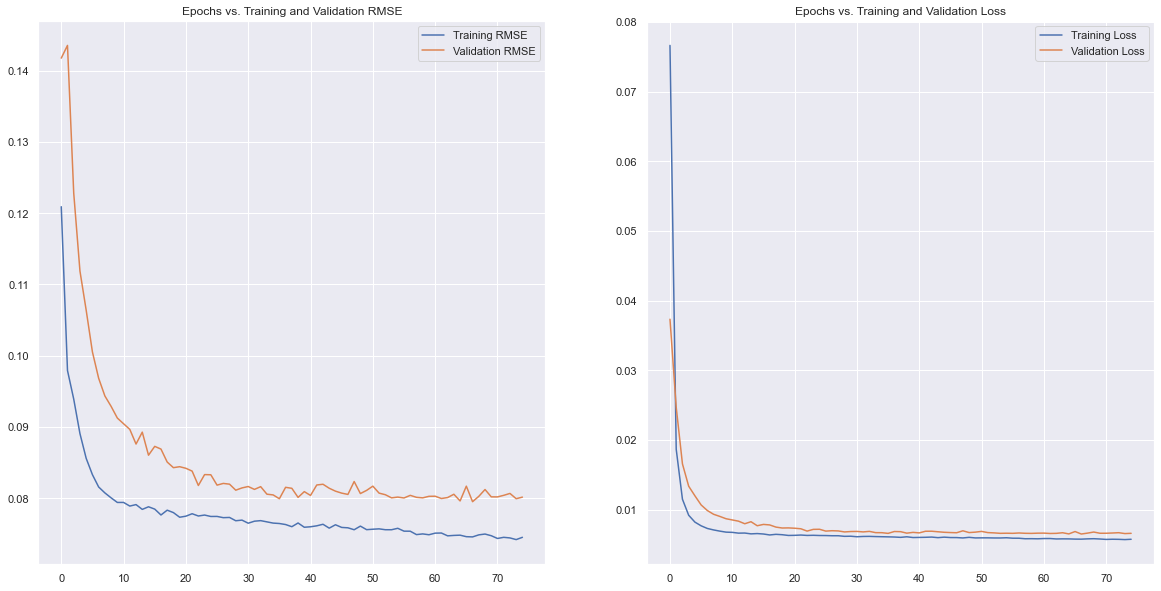

In [94]:
plot_model_rmse_and_loss(LSTM_Model)

In [95]:
forecast = LSTM.predict(X_test)
LSTM_forecast = scaler.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test, LSTM_forecast))
print('RMSE of hour-ahead electricity price multivariate LSTM forecast: {}' .format(round(rmse_lstm, 3)))

RMSE of hour-ahead electricity price multivariate LSTM forecast: 0.799


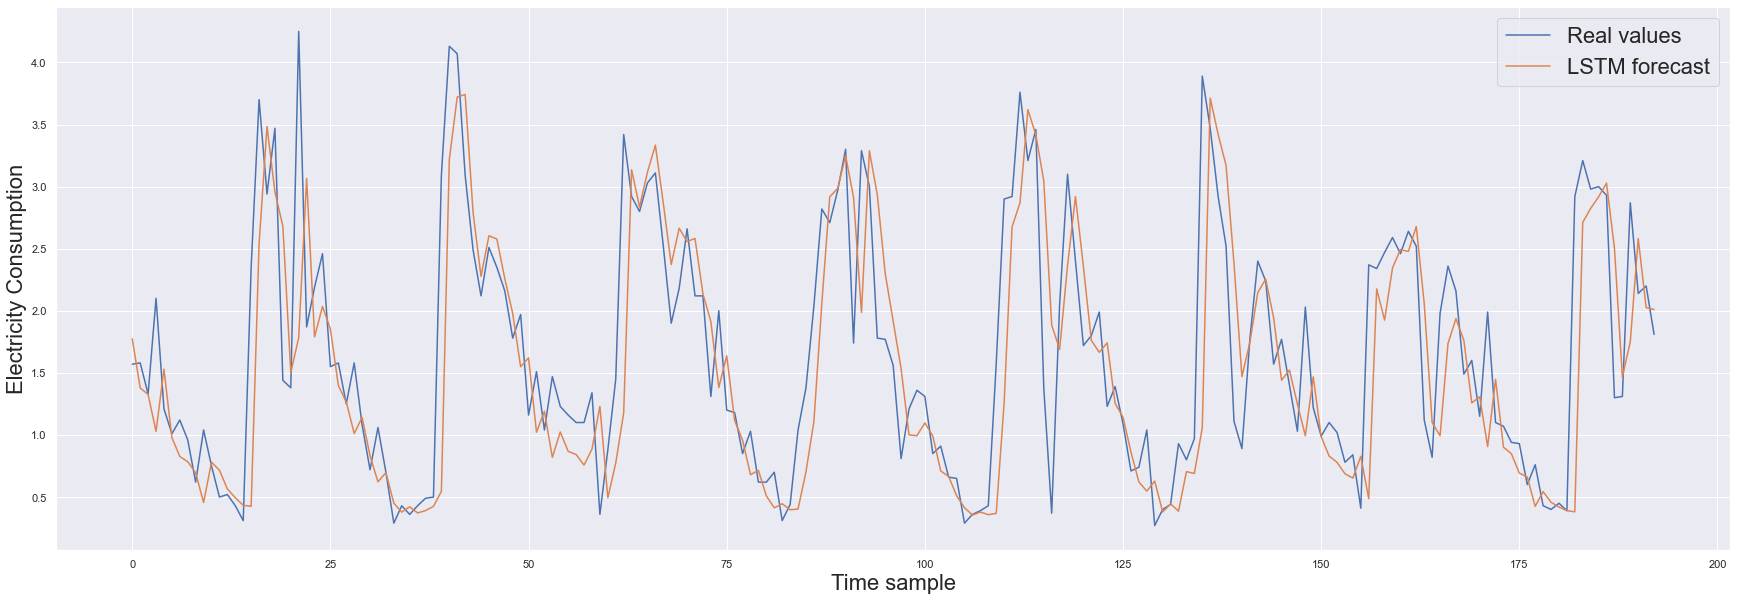

In [96]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[5200:], label='Real values')
ax.plot(LSTM_forecast[5200:], label='LSTM forecast')
ax.legend(prop={'size':22})
plt.show()

The LSTM model performed slighlty worse than the MLP. We see the same issue of overfitting and an inability to map sharp peaks and valleys in consumption patterns. This is again evident in time step ~25, ~125 and ~135

## CNN

First we determine the learning rate

In [97]:
tf.keras.backend.clear_session()

cnn_lr = tf.keras.models.Sequential([ Conv1D(filters=50, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
cnn_lr.compile(loss=loss, optimizer=optimizer, metrics=metric)
learning_rate = cnn_lr.fit(train, epochs=50, validation_data=val, callbacks=[lr_schedule])

Epoch 1/50
197/197 [==============================] - 0s 2ms/step - loss: 0.0126 - root_mean_squared_error: 0.1072 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044
Epoch 2/50
197/197 [==============================] - 0s 2ms/step - loss: 0.0095 - root_mean_squared_error: 0.0977 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0951
Epoch 3/50
197/197 [==============================] - 0s 2ms/step - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0929
Epoch 4/50
197/197 [==============================] - 0s 2ms/step - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 5/50
197/197 [==============================] - 0s 2ms/step - loss: 0.0067 - root_mean_squared_error: 0.0820 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0832
Epoch 6/50
197/197 [==============================] - 0s 2ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0067 - val_

197/197 [==============================] - 0s 1ms/step - loss: 0.1682 - root_mean_squared_error: 0.4102 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1456
Epoch 49/50
197/197 [==============================] - 0s 1ms/step - loss: 0.0351 - root_mean_squared_error: 0.1874 - val_loss: 0.0514 - val_root_mean_squared_error: 0.2266
Epoch 50/50
197/197 [==============================] - 0s 1ms/step - loss: 0.2743 - root_mean_squared_error: 0.5237 - val_loss: 0.0475 - val_root_mean_squared_error: 0.2179


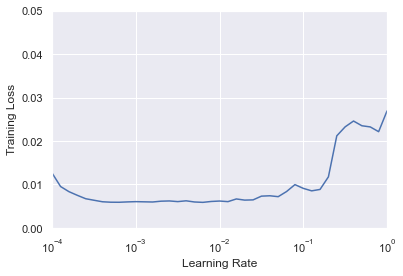

In [98]:
plot_learning_rate_schedule(learning_rate, 0.05)

In [99]:
CNN = tf.keras.models.Sequential([Conv1D(filters = 75, kernel_size = 2, strides = 1, padding = 'causal',
                                         activation = 'relu', input_shape = input_shape),
                                  Flatten(),
                                  Dense(30, activation='relu'),
                                  Dense(1),
                                 ])

optimizer = tf.keras.optimizers.Adam(lr = .0001, amsgrad=True)
CNN.compile(loss = loss, optimizer = optimizer, metrics = metric)
CNN_Model = CNN.fit(train, epochs = 100, validation_data = val) 

Epoch 1/100
197/197 [==============================] - 0s 2ms/step - loss: 0.0141 - root_mean_squared_error: 0.1413 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1138
Epoch 2/100
197/197 [==============================] - 0s 1ms/step - loss: 0.0109 - root_mean_squared_error: 0.1042 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1037
Epoch 3/100
197/197 [==============================] - 0s 1ms/step - loss: 0.0094 - root_mean_squared_error: 0.0967 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0934
Epoch 4/100
197/197 [==============================] - 0s 1ms/step - loss: 0.0083 - root_mean_squared_error: 0.0908 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0902
Epoch 5/100
197/197 [==============================] - 0s 2ms/step - loss: 0.0076 - root_mean_squared_error: 0.0872 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0879
Epoch 6/100
197/197 [==============================] - 0s 1ms/step - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0074 

197/197 [==============================] - 0s 1ms/step - loss: 0.0052 - root_mean_squared_error: 0.0719 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779
Epoch 49/100
197/197 [==============================] - 0s 1ms/step - loss: 0.0052 - root_mean_squared_error: 0.0718 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0777
Epoch 50/100
197/197 [==============================] - 0s 1ms/step - loss: 0.0052 - root_mean_squared_error: 0.0718 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0782
Epoch 51/100
197/197 [==============================] - 0s 1ms/step - loss: 0.0052 - root_mean_squared_error: 0.0718 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779
Epoch 52/100
197/197 [==============================] - 0s 1ms/step - loss: 0.0052 - root_mean_squared_error: 0.0718 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0780
Epoch 53/100
197/197 [==============================] - 0s 1ms/step - loss: 0.0051 - root_mean_squared_error: 0.0717 - val_loss: 0.0061 - val_r

197/197 [==============================] - 0s 1ms/step - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779
Epoch 96/100
197/197 [==============================] - 0s 1ms/step - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0778
Epoch 97/100
197/197 [==============================] - 0s 1ms/step - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0778
Epoch 98/100
197/197 [==============================] - 0s 1ms/step - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0778
Epoch 99/100
197/197 [==============================] - 0s 1ms/step - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0778
Epoch 100/100
197/197 [==============================] - 0s 1ms/step - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0060 - val_

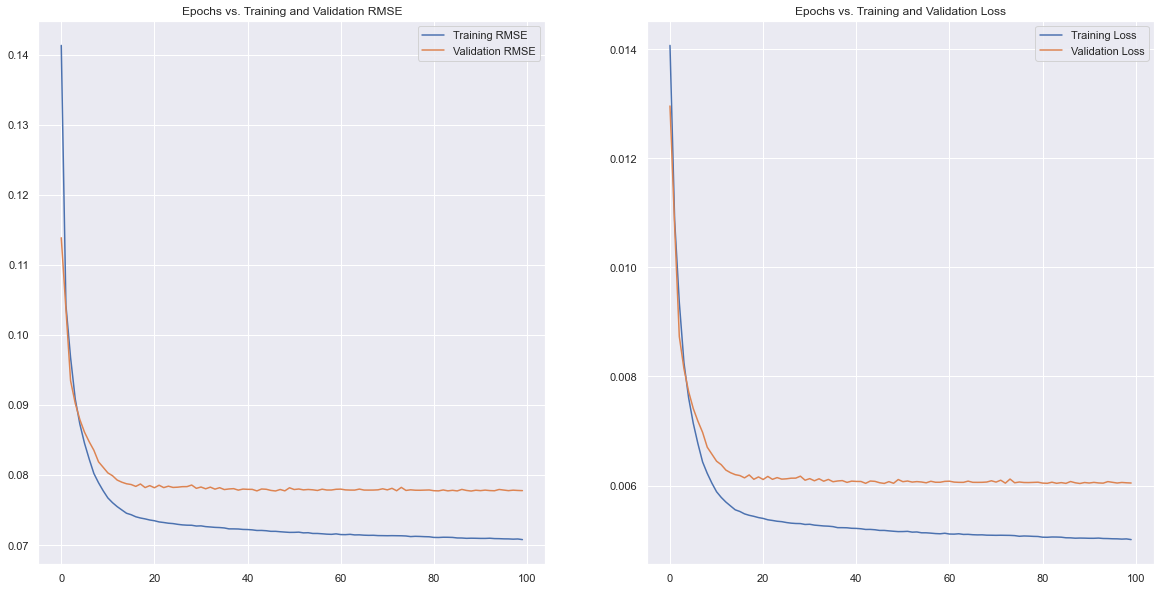

In [100]:
plot_model_rmse_and_loss(CNN_Model)

Ideal learning rate in .0001

In [101]:
forecast =  CNN.predict(X_test)
CNN_forecast = scaler.inverse_transform(forecast)

rmse_CNN = sqrt(mean_squared_error(y_test, CNN_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN forecast: {}' .format(round(rmse_CNN, 3)))

RMSE of hour-ahead electricity price multivariate CNN forecast: 0.75


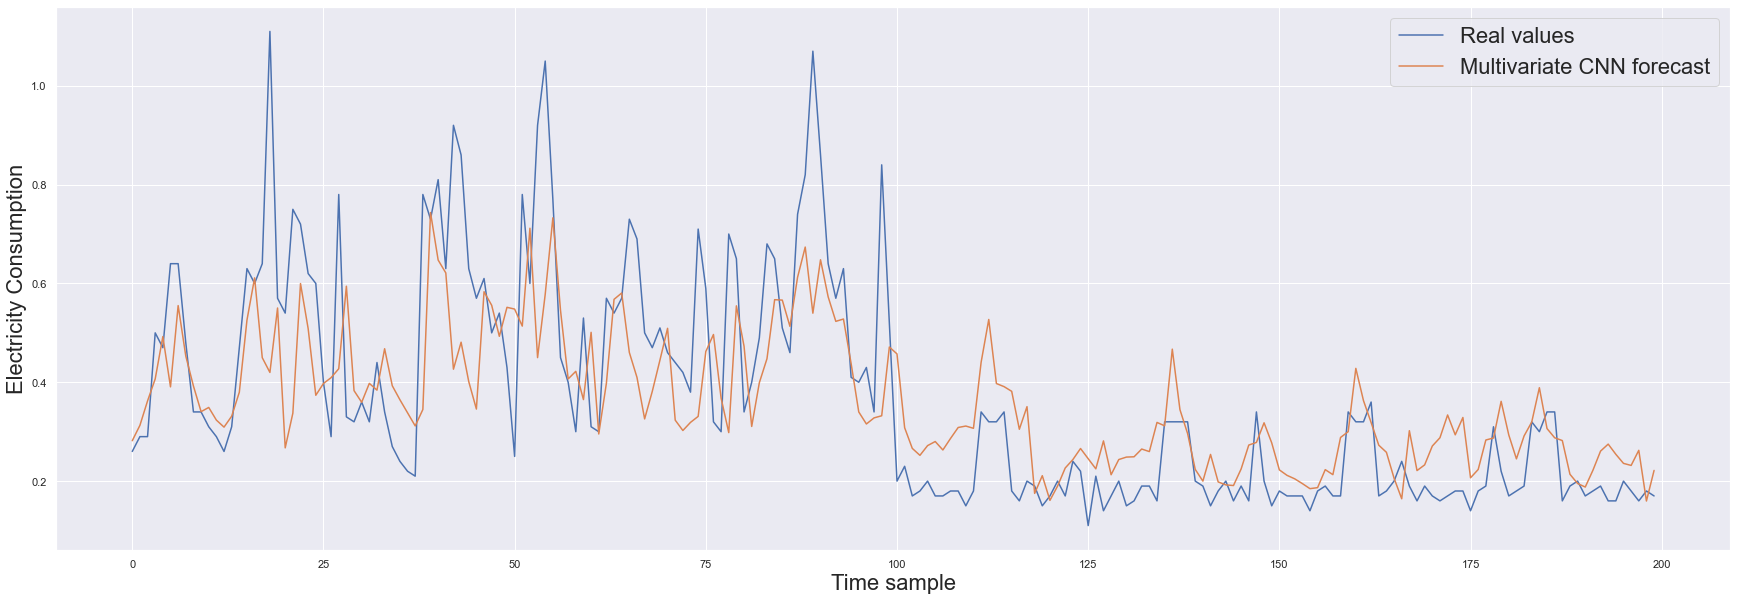

In [102]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[500:700], label='Real values')
ax.plot(CNN_forecast[500:700], label='Multivariate CNN forecast')
ax.legend(prop={'size':22})
plt.show()

The CNN models performance is nearly identical to the LSTM network. 

## Hybrid CNN-LSTM

In [105]:
tf.keras.backend.clear_session()

cnn_lstm = tf.keras.models.Sequential([ Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
cnn_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)
learning_rate = cnn_lstm.fit(train, epochs=50, validation_data=val, callbacks=[lr_schedule])

Epoch 1/50
197/197 [==============================] - 2s 11ms/step - loss: 0.0170 - root_mean_squared_error: 0.1229 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1370
Epoch 2/50
197/197 [==============================] - 2s 8ms/step - loss: 0.0119 - root_mean_squared_error: 0.1090 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 3/50
197/197 [==============================] - 2s 8ms/step - loss: 0.0097 - root_mean_squared_error: 0.0984 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1014
Epoch 4/50
197/197 [==============================] - 2s 9ms/step - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0925
Epoch 5/50
197/197 [==============================] - 2s 9ms/step - loss: 0.0076 - root_mean_squared_error: 0.0872 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893
Epoch 6/50
197/197 [==============================] - 2s 9ms/step - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 0.0078 - val

197/197 [==============================] - 2s 10ms/step - loss: 0.0630 - root_mean_squared_error: 0.2509 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1433
Epoch 49/50
197/197 [==============================] - 2s 9ms/step - loss: 0.1555 - root_mean_squared_error: 0.3943 - val_loss: 0.0484 - val_root_mean_squared_error: 0.2200
Epoch 50/50
197/197 [==============================] - 2s 10ms/step - loss: 0.0941 - root_mean_squared_error: 0.3067 - val_loss: 0.0216 - val_root_mean_squared_error: 0.1470


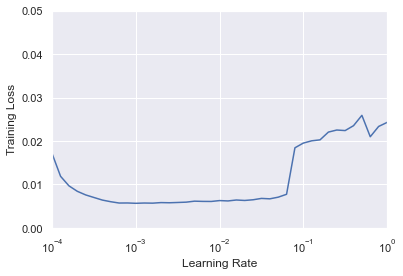

In [106]:
plot_learning_rate_schedule(learning_rate, 0.05)

In [107]:
CNN_LSTM = tf.keras.models.Sequential([Conv1D(filters=100, kernel_size=2,strides=1, padding='causal',
                                              activation='relu', input_shape = input_shape),
                                       LSTM(50, return_sequences=True),
                                       Flatten(),
                                       Dense(30, activation='relu'),
                                       Dense(1) 
                                      ])

optimizer = tf.keras.optimizers.Adam(lr = .0001, amsgrad=True)
CNN_LSTM.compile(loss = loss, optimizer = optimizer, metrics = metric)
CNN_LSTM_Model = CNN_LSTM.fit(train, epochs = 100, validation_data = val) 

Epoch 1/100
197/197 [==============================] - 1s 7ms/step - loss: 0.0161 - root_mean_squared_error: 0.1306 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1323
Epoch 2/100
197/197 [==============================] - 1s 5ms/step - loss: 0.0123 - root_mean_squared_error: 0.1108 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1035
Epoch 3/100
197/197 [==============================] - 1s 5ms/step - loss: 0.0098 - root_mean_squared_error: 0.0991 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0987
Epoch 4/100
197/197 [==============================] - 1s 5ms/step - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0978
Epoch 5/100
197/197 [==============================] - 1s 5ms/step - loss: 0.0081 - root_mean_squared_error: 0.0900 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0958
Epoch 6/100
197/197 [==============================] - 1s 5ms/step - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0087 

197/197 [==============================] - 1s 5ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0772
Epoch 49/100
197/197 [==============================] - 1s 5ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0771
Epoch 50/100
197/197 [==============================] - 1s 5ms/step - loss: 0.0052 - root_mean_squared_error: 0.0724 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0771
Epoch 51/100
197/197 [==============================] - 1s 5ms/step - loss: 0.0052 - root_mean_squared_error: 0.0724 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0771
Epoch 52/100
197/197 [==============================] - 1s 5ms/step - loss: 0.0052 - root_mean_squared_error: 0.0724 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0771
Epoch 53/100
197/197 [==============================] - 1s 5ms/step - loss: 0.0052 - root_mean_squared_error: 0.0723 - val_loss: 0.0059 - val_r

197/197 [==============================] - 1s 5ms/step - loss: 0.0051 - root_mean_squared_error: 0.0713 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0771
Epoch 96/100
197/197 [==============================] - 1s 5ms/step - loss: 0.0051 - root_mean_squared_error: 0.0713 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0771
Epoch 97/100
197/197 [==============================] - 1s 5ms/step - loss: 0.0051 - root_mean_squared_error: 0.0712 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0772
Epoch 98/100
197/197 [==============================] - 1s 5ms/step - loss: 0.0051 - root_mean_squared_error: 0.0712 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0771
Epoch 99/100
197/197 [==============================] - 1s 5ms/step - loss: 0.0051 - root_mean_squared_error: 0.0712 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0771
Epoch 100/100
197/197 [==============================] - 1s 6ms/step - loss: 0.0051 - root_mean_squared_error: 0.0712 - val_loss: 0.0059 - val_

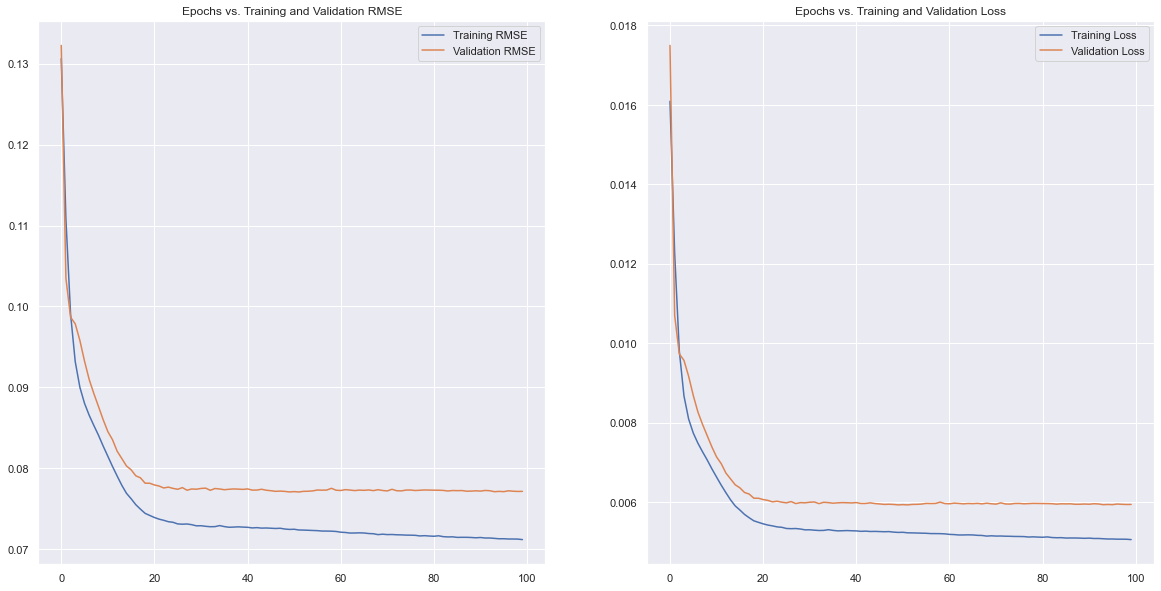

In [108]:
plot_model_rmse_and_loss(CNN_LSTM_Model)

In [109]:
forecast =  CNN_LSTM.predict(X_test)
CNN_LSTM_forecast = scaler.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test, CNN_LSTM_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN_LSTM forecast: {}' .format(round(rmse_lstm, 3)))

RMSE of hour-ahead electricity price multivariate CNN_LSTM forecast: 0.734


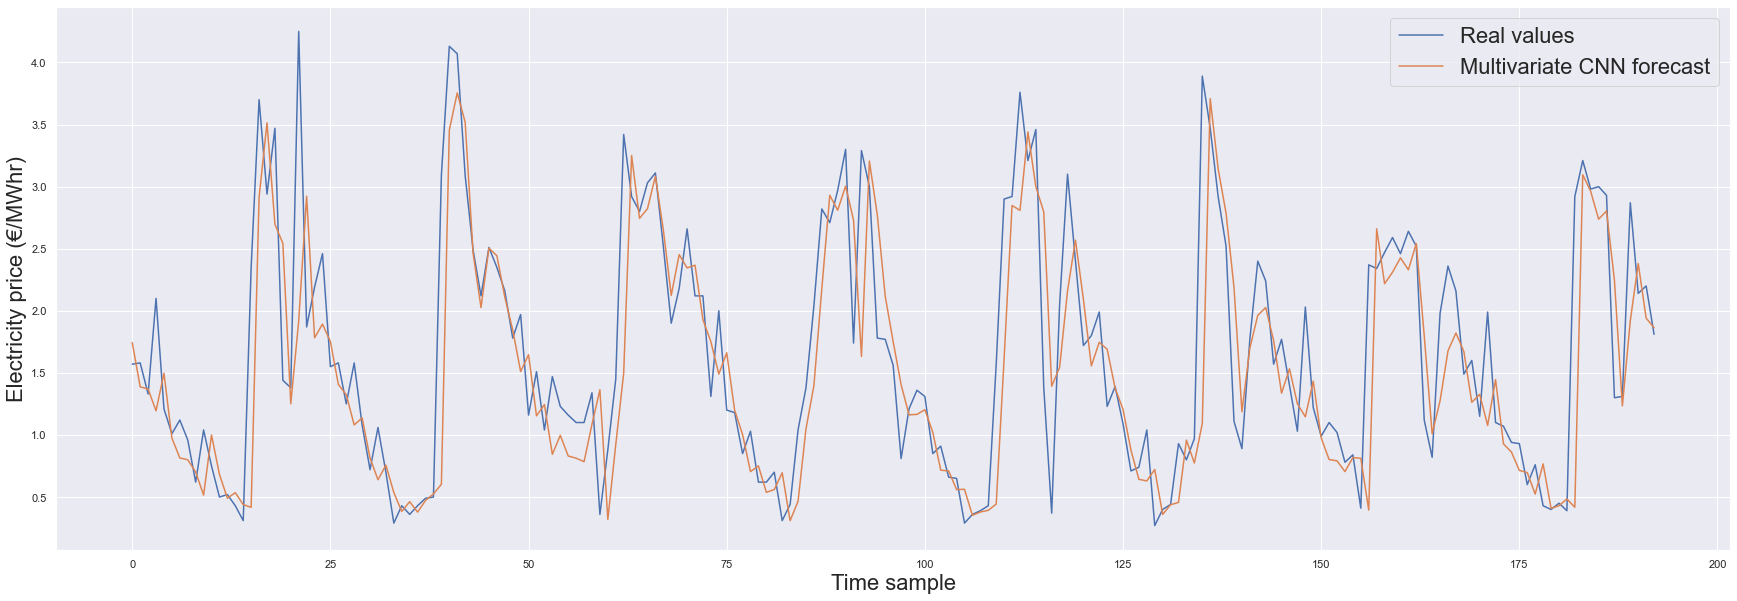

In [110]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity price (€/MWhr)', fontsize=22)
ax.plot(y_test_inv[5200:], label='Real values')
ax.plot(CNN_LSTM_forecast[5200:], label='Multivariate CNN forecast')
ax.legend(prop={'size':22})
plt.show()